In [1]:
import torch
import numpy as np
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, device
from torch.nn.utils.parametrizations import weight_norm
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES, GRAPH_EMBEDDING_SIZE
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from functools import partial
from IPython import display
import os

### TRAINING HELPERS

In [2]:
class GradientParameterMonitor:
    def __init__(self, model, writer : SummaryWriter, log_frequency=100):
        self.model = model
        self.log_frequency = log_frequency
        self.step = 0
        self.writer = writer

    def update(self):
        self.step += 1
        if self.step % self.log_frequency == 0:
            for name, param in self.model.named_parameters():
                if "node" in name:
                    if param.grad is not None:
                        self._log_tensor_stats(f'{name}/grad', param.grad)
                    self._log_tensor_stats(f'{name}/param', param.data)

    def _log_tensor_stats(self, tag_prefix, tensor):
        stats = self._get_tensor_stats(tensor)
        for stat_name, value in stats.items():
            self.writer.add_scalar(f'Monitor/{tag_prefix}/{stat_name}', value, self.step)

    def _get_tensor_stats(self, tensor):
        return {
            'mean': tensor.mean().item(),
            # 'std': tensor.std().item(),
            'min': tensor.min().item(),
            'max': tensor.max().item(),
            # 'norm': torch.norm(tensor).item()
        }

In [3]:
@torch.no_grad()
def batched_dot(a : Tensor, b : Tensor):
    return (a * b).sum(dim = -1, keepdim = True)

@torch.no_grad()
def ToIscosceles(x : Tensor):
    m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

    # To Iscosceles representation
    y = x.clone().to(torch.double)
    c = y[...,13:15] # torch.tensor([1.76, 2.21])
    r = y[...,15,None] # torch.tensor([1.0])
    alpha = y[...,16,None] * 2 * math.pi # torch.tensor([0.211])
    beta = y[...,17,None] * 2 * math.pi # torch.tensor([0.987])

    a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
    b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)
    r_s = torch.where(batched_dot((a - b) @ m, a - c) > 0, -r, r)

    y[...,13:15] = a
    y[...,15:17] = b
    y[...,17] = r_s.squeeze(-1)

    return y.to(torch.float32)

@torch.no_grad()
def ToNaive(x : Tensor):
    m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

    x = x.clone().to(torch.double)
    a = x[...,13:15]
    b = x[...,15:17]
    r_s = x[...,17,None]

    # To Naive representation
    d = a - b

    w = batched_dot(d, d).sqrt()
    h = torch.sqrt(r_s ** 2 - w ** 2 / 4)

    c = b + d / 2 + h / w * d @ m * r_s.sign()

    al = (a - c) / r_s.abs()
    al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
    be = (b - c) / r_s.abs()
    be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

    x[...,13:18] = torch.cat([c, torch.abs(r_s), al, be], dim = -1)
    x[x.isnan()] = 0
    return x.to(torch.float)


### MODULES

In [4]:
def create_schedule(cumulative_precisions : Tensor, device : device):
  cumulative_variances = 1 - cumulative_precisions
  variances = torch.cat([torch.Tensor([0]).to(device), 1 - (cumulative_precisions[1:] / cumulative_precisions[:-1])]).clamp(.0001, .9999)
  precisions = 1 - variances
  sqrt_cumulative_precisions = torch.sqrt(cumulative_precisions)
  sqrt_cumulative_variances = torch.sqrt(cumulative_variances)
  sqrt_precisions = torch.sqrt(precisions)
  sqrt_variances = torch.sqrt(variances)
  sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(device), torch.sqrt(variances[1:] * cumulative_variances[:-1] / cumulative_variances[1:])])

  return cumulative_variances, variances, precisions, sqrt_cumulative_precisions, sqrt_cumulative_variances, sqrt_precisions, sqrt_variances, sqrt_posterior_variances

class CosineNoiseScheduler(nn.Module):
  def __init__(self, max_timestep : int, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep
    self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

    # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672     1.00015543316 is 1/a(0), for offset = .008
    self.cumulative_precisions = torch.cos((torch.linspace(0, 1, self.max_timestep + 1).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2 * 1.00015543316
    self.cumulative_variances, self.variances, self.precisions, self.sqrt_cumulative_precisions, self.sqrt_cumulative_variances, self.sqrt_precisions, self.sqrt_variances, self.sqrt_posterior_variances = create_schedule(self.cumulative_precisions, self.device)

    self.clip_value = -10
    # Discrete Cosine Schedule
    self.disc_cumulative_precisions = 1 - torch.linspace(0, 1, self.max_timestep + 1).to(self.device) ** (1/16)
    self.disc_cumulative_variances, self.disc_variances, self.disc_precisions, self.sqrt_disc_cumulative_precisions, self.sqrt_disc_cumulative_variances, self.sqrt_disc_precisions, self.sqrt_disc_variances, self.sqrt_disc_posterior_variances = create_schedule(self.disc_cumulative_precisions, self.device)
    # D = 5
    # x0 = torch.eye(n = 1, m = D, device = self.device)
    # self.disc_cumulative_precisions = self.sqrt_cumulative_precisions.unsqueeze(1)
    # temp = x0.log().clamp(self.clip_value)
    # self.disc_cumulative_precisions = torch.sum(torch.log(D * self.disc_cumulative_precisions * x0 + (1 - self.disc_cumulative_precisions)) * temp, dim = -1) / (temp * temp).sum(dim = -1)
    # self.disc_cumulative_precisions = (1 + self.disc_cumulative_precisions ** -2) ** -1
    # self.disc_cumulative_variances, self.disc_variances, self.disc_precisions, self.sqrt_disc_cumulative_precisions, self.sqrt_disc_cumulative_variances, self.sqrt_disc_precisions, self.sqrt_disc_variances, self.sqrt_disc_posterior_variances = create_schedule(self.disc_cumulative_precisions, self.device)
  
  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    ''' Apply noise to graph '''
    noisy_nodes = torch.zeros(size = nodes.size(), device = nodes.device)
    noisy_edges = torch.zeros(size = edges.size(), device = edges.device)
    # nodes = batch_size x num_nodes x NODE_FEATURE_DIMENSION ; edges = batch_size x num_nodes x num_nodes x EDGE_FEATURE_DIMENSION
    bernoulli_is_constructible = nodes[:,:,0] # batch_size x num_nodes x 1
    categorical_primitive_types = nodes[:,:,1:6] # batch_size x num_nodes x 5
    gaussian_primitive_parameters = nodes[:,:,6:] # batch_size x num_nodes x 14
    # subnode just means if the constraint applies to the start, center, or end of a primitive
    categorical_subnode_a_types = edges[:,:,:,0:4] # batch_size x num_nodes x 4
    categorical_subnode_b_types = edges[:,:,:,4:8] # batch_size x num_nodes x 4
    categorical_constraint_types = edges[:,:,:,8:] # batch_size x num_nodes x 9
    # IsConstructible noise
    noisy_nodes[:,:,0] = self.apply_binary_noise(bernoulli_is_constructible, timestep)
    # Primitive Types noise
    noisy_nodes[:,:,1:6] = self.apply_discrete_noise(categorical_primitive_types, timestep) # noised_primitive_types
    # Primitive parameters noise
    gaussian_noise = torch.randn_like(gaussian_primitive_parameters) # standard gaussian noise
    noisy_nodes[:,:,6:] = self.apply_gaussian_noise(gaussian_primitive_parameters, timestep, gaussian_noise)
    # Subnode A noise
    noisy_edges[:,:,:,0:4] = self.apply_discrete_noise(categorical_subnode_a_types, timestep) # noised_subnode_a_types
    # Subnode B noise
    noisy_edges[:,:,:,4:8] = self.apply_discrete_noise(categorical_subnode_b_types, timestep) # noised_subnode_a_types
    # Constraint Types noise
    noisy_edges[:,:,:,8:] = self.apply_discrete_noise(categorical_constraint_types, timestep) # noised_constraint_types
    return noisy_nodes, noisy_edges, gaussian_noise
  
  def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
    return self.sqrt_precisions[timestep] * parameters + self.sqrt_variances[timestep] * gaussian_noise
  
  def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor = None):
    if type(timestep) is int: timestep = [timestep]
    # parameters shape is batch_size x num_nodes x num_params
    # gaussian_noise shape is batch_size x num_nodes x num_params
    batched_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
    batched_variances = self.sqrt_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)
    return batched_precisions * parameters + batched_variances * gaussian_noise
  
  def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_params : Tensor, timestep : int):
    if timestep > 1:
      sqrt_prev_cumul_prec = self.sqrt_cumulative_precisions[timestep - 1]
      var = self.variances[timestep]
      sqrt_prec = self.sqrt_precisions[timestep]
      prev_cumul_var = self.cumulative_variances[timestep - 1]
      cumul_var = self.cumulative_variances[timestep]
      
      denoised_mean = (sqrt_prev_cumul_prec * var * pred_params + sqrt_prec * prev_cumul_var * curr_params) / cumul_var

      gaussian_noise = torch.randn_like(curr_params)
      return denoised_mean + gaussian_noise * self.sqrt_posterior_variances[timestep]
    else:
      return pred_params # denoised_mean
    
  def get_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: 
      assert timestep > 0; 
      assert timestep < self.max_timestep; 
      timestep = [timestep]
    
    batched_precisions = self.precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: 
      assert timestep > 0; 
      assert timestep < self.max_timestep; 
      timestep = [timestep]

    batched_precisions = self.cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_posterior_transition_matrix(self, xt : Tensor, timestep : Tensor | int) -> torch.Tensor:
    xt_size, xt = self.flatten_middle(xt) # (b, n, d) or (b, n * n, d), for convenience let m = n or n * n
    d = xt_size[-1]
    qt = xt @ self.get_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
    qt_bar = xt @ self.get_cumulative_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
    q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
    q = q * self.get_cumulative_transition_matrix(d, timestep - 1).unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)
    return q.view(size = xt_size + (d,)) # reshape into (b, n, d, d) or (b, n, n, d, d)
  
  def apply_discrete_noise(self, x_one_hot : Tensor, timestep : Tensor | int):
    # size, x = self.flatten_middle(x_one_hot)
    # q = self.get_cumulative_transition_matrix(size[-1], timestep) # (b, d, d) or (1, d, d)
    # distribution = x @ q # (b, n, d) or (b, n * n, d)
    # distribution = distribution.view(size) # (b, n, d) or (b, n, n, d)
    # return self.sample_discrete_distribution(distribution).float()
    return self.apply_disc_noise(x_one_hot, timestep)
  
  def apply_disc_noise(self, x : Tensor, timestep : Tensor | int):
    size, x = self.flatten_middle(x)
    logits = x.log().clamp(self.clip_value)
    noise = torch.randn_like(logits)

    batched_precisions = self.sqrt_disc_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
    batched_variances = self.sqrt_disc_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)

    return torch.softmax(batched_precisions * logits + batched_variances * noise, dim = -1).reshape(size)

  def apply_disc_posterior_step(self, curr_class_probs : Tensor, pred_class_probs : Tensor, timestep : int):
    if timestep > 1:
      sqrt_prev_cumul_prec = self.sqrt_disc_cumulative_precisions[timestep - 1]
      var = self.disc_variances[timestep]
      sqrt_prec = self.sqrt_disc_precisions[timestep]
      prev_cumul_var = self.disc_cumulative_variances[timestep - 1]
      cumul_var = self.disc_cumulative_variances[timestep]

      # class_probs_size, class_probs = self.flatten_middle(curr_class_probs)
      # pred_probs_size, pred_probs = self.flatten_middle(pred_class_probs)

      curr_logits = curr_class_probs.log().clamp(self.clip_value)
      pred_logits = pred_class_probs.log().clamp(self.clip_value)
      
      denoised_mean = (sqrt_prev_cumul_prec * var * pred_logits + sqrt_prec * prev_cumul_var * curr_logits) / cumul_var

      gaussian_noise = torch.randn_like(curr_class_probs)
      return torch.softmax(denoised_mean + gaussian_noise * self.sqrt_disc_posterior_variances[timestep], dim = -1) # .reshape(pred_probs_size)
    else:
      return pred_class_probs # denoised_mean
  
  def apply_multinomial_posterior_step(self, classes_one_hot : Tensor, pred_class_probs : Tensor, timestep : int):
    # # classes_one_hot = (b, n, d) or (b, n, n, d)
    # # pred_class_probs = (b, n, d) or (b, n, n, d)
    # if timestep > 1:
    #   q = self.get_posterior_transition_matrix(classes_one_hot, timestep) # (b, n, d, d) or (b, n, n, d, d)
    #   pred_class_probs = pred_class_probs.unsqueeze(-2) # (b, n, 1, d) or (b, n, n, 1, d), make probs into row vector
    #   posterior_distribution = pred_class_probs @ q # (b, n, 1, d) or (b, n, n, 1, d), batched vector-matrix multiply
    #   posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d) or (b, n, n, d)
    #   return self.sample_discrete_distribution(posterior_distribution).float()
    # else:
    #   return pred_class_probs

    return self.apply_disc_posterior_step(classes_one_hot, pred_class_probs, timestep)
    
  def apply_binary_noise(self, boolean_flag : Tensor, timestep : int | Tensor):
    boolean_flag = boolean_flag.unsqueeze(-1)
    one_hot = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
    noised_one_hot = self.apply_discrete_noise(one_hot, timestep) # (b, n, 2)
    return noised_one_hot[...,1] # (b, n)
  
  def apply_bernoulli_posterior_step(self, boolean_flag : Tensor, pred_boolean_prob : Tensor, timestep : int):
    if timestep > 1:
      boolean_flag = boolean_flag.unsqueeze(-1) # b, n, 1
      pred_boolean_prob = pred_boolean_prob.unsqueeze(-1) # b, n, 1
      one_hot_xt = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
      probs = torch.cat([1 - pred_boolean_prob, pred_boolean_prob], dim = -1) # (b, n, 2)
      noised_one_hot = self.apply_multinomial_posterior_step(one_hot_xt, probs, timestep) # (b, n, 2)
      return noised_one_hot[...,1] # (b, n)
    else:
      return pred_boolean_prob
    
  def sample_discrete_distribution(self, tensor : Tensor):
    # size = tensor.size()
    # num_classes = size[-1]
    # return F.one_hot(tensor.reshape(-1, num_classes).multinomial(1), num_classes).reshape(size)

    noise = -torch.log(-torch.log(torch.rand_like(tensor))) # self.gumbel_dist.sample(tensor.shape).squeeze(-1).to(self.device)
    return torch.softmax(tensor.log() + noise, dim = -1)
  
  def flatten_middle(self, x : Tensor):
    prev_size = x.size() # shape of x_one_hot is (b, n, d) or (b, n, n, d)
    return prev_size, x.view(prev_size[0], -1, prev_size[-1]) # (b, n, d) or (b, n * n, d)
  
  def sample_latent(self, batch_size : int) -> tuple[Tensor, Tensor] :
    nodes = torch.zeros(size = (batch_size, MAX_NUM_PRIMITIVES, NODE_FEATURE_DIMENSION), device = self.device)
    edges = torch.zeros(size = (batch_size, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, EDGE_FEATURE_DIMENSION), device = self.device)

    # Boolean Variable for IsConstructible
    nodes[...,:0] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, 1), device = self.device).sigmoid()
    # Multinomial for Node type
    nodes[...,1:6] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, 5), device = self.device).softmax(dim = -1)
    # Gaussian for Node parameters
    nodes[...,6:] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, 14), device = self.device)

    # Multinomial for Subnode A type
    edges[...,0:4] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, 4), device = self.device).softmax(dim = -1)
    # Multinomial for Subnode B type
    edges[...,4:8] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, 4), device = self.device).softmax(dim = -1)
    # Multinomial for Edge type
    edges[...,8:] = torch.randn(size = (batch_size, MAX_NUM_PRIMITIVES, MAX_NUM_PRIMITIVES, 9), device = self.device).softmax(dim = -1)

    return nodes, edges

In [5]:
class TimeEmbedder(nn.Module):
  def __init__(self, max_timestep : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    self.max_steps = max_timestep + 1
    self.max_timestep = max_timestep
      
    timesteps = torch.arange(self.max_steps, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.time_embs = torch.zeros(self.max_steps, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.time_embs[:, 0::2] = torch.sin(timesteps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.time_embs[:, 1::2] = torch.cos(timesteps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, timestep : Tensor):
    return self.time_embs[timestep] # batch_size x embedding_dimension

In [6]:
# class MPSiLU(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.silu = nn.SiLU()
    
#     def forward(self, x):
#         return self.silu(x) / 0.596

In [7]:
# class TransformerLayer(nn.Module):
#     def __init__(self, num_heads : int, node_dim : int, edge_dim : int, device : torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim

#         self.lin_node_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
#         self.lin_node_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)

#         self.lin_edge_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)
#         self.lin_edge_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)

#         self.attention_heads = MultiHeadAttention(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = device)

#         self.layer_norm_nodes = nn.Sequential(nn.LeakyReLU(0.01),
#                                               nn.LayerNorm(normalized_shape = self.node_dim, device = device, elementwise_affine = False, bias = False), 
#                                               nn.LeakyReLU(0.01),
#                                              )

#         self.layer_norm_edges = nn.Sequential(nn.LeakyReLU(0.01), 
#                                               nn.LayerNorm(normalized_shape = self.edge_dim, device = device, elementwise_affine = False, bias = False), 
#                                               nn.LeakyReLU(0.01),
#                                              )

#         self.mlp_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                     #    nn.Dropout(p = 0.1),
#                                        nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
#                                       )
        
#         self.mlp_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                     #    nn.Dropout(p = 0.1),
#                                        nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
#                                       )
        
#         self.layer_norm_nodes2 = nn.Sequential(nn.LeakyReLU(0.01),
#                                                nn.LayerNorm(normalized_shape = self.node_dim, device = device, elementwise_affine = False, bias = False), 
#                                                nn.LeakyReLU(0.01),
#                                               )

#         self.layer_norm_edges2 = nn.Sequential(nn.LeakyReLU(0.01),
#                                                nn.LayerNorm(normalized_shape = self.edge_dim, device = device, elementwise_affine = False, bias = False), 
#                                                nn.LeakyReLU(0.01),
#                                               )
        
#         self.sftmx_norm_time = nn.Sequential(# nn.LeakyReLU(0.01),
#                                                nn.Softmax(dim = 1),
#                                               )
    
#     def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor) -> Tuple[Tensor, Tensor]:
#       # Inject timestep information
#       time_node_add = self.lin_node_add_embs(time_emb).unsqueeze(1)
#       time_node_mul = self.lin_node_mul_embs(time_emb).unsqueeze(1)
#       nodes = nodes * time_node_mul + nodes + time_node_add

#       time_edge_add = self.lin_edge_add_embs(time_emb).unsqueeze(1).unsqueeze(1)
#       time_edge_mul = self.lin_edge_mul_embs(time_emb).unsqueeze(1).unsqueeze(1)
#       edges = edges * time_edge_mul + edges + time_edge_add
#       # edges = edges * time_mul.unsqueeze(1).unsqueeze(1) + edges + time_add.unsqueeze(1).unsqueeze(1)

#       # Perform multi head attention
#       # attn_nodes, attn_edges = checkpoint(self.attention_heads, nodes, edges, use_reentrant = False) # batch_size x num_nodes x node_dim ; batch_size x num_nodes x num_nodes x edge_dim
#       attn_nodes, attn_edges, attn_embs = self.attention_heads(nodes, edges, time_emb)

#       # Layer normalization with a skip connection
#       attn_nodes = self.layer_norm_nodes(attn_nodes + nodes) # batch_size x num_nodes x node_dim
#       attn_edges = self.layer_norm_edges(attn_edges + edges) # batch_size x num_nodes x num_nodes x edge_dim

#       del nodes
#       del edges

#       # MLP out
#       new_nodes = self.mlp_nodes(attn_nodes) # batch_size x num_nodes x node_dim
#       new_edges = self.mlp_edges(attn_edges) # batch_size x num_nodes x num_nodes x edge_dim

#       # Second layer normalization with a skip connection
#       new_nodes = self.layer_norm_nodes2(new_nodes + attn_nodes) # batch_size x num_nodes x node_dim
#       new_edges = self.layer_norm_edges2(new_edges + attn_edges) # batch_size x num_nodes x num_nodes x edge_dim
#       del attn_nodes
#       del attn_edges

#       return new_nodes, new_edges, attn_embs # F.normalize(attn_embs, p = 2.0, dim = 1, eps = 1e-4)
    
# # Outer Product Attention Head
# class MultiHeadAttention(nn.Module):
#     def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.num_heads = num_heads
#         self.attn_dim = node_dim // num_heads

#         self.lin_query = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
#                                       )
#         self.lin_key = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
#                                       )
#         self.lin_value = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
#                                       )

#         self.lin_mul = nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device)
#         self.lin_add = nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device)
#         #self.edge_film = FiLM(self.edge_dim, self.node_dim, device = device)

#         # self.lin_tim_weight = nn.Linear(in_features = self.node_dim, out_features = 1, device = device)
#         # self.lin_tim_mul = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
#         # self.lin_tim_add = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)

#         self.lin_nodes_out = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
#         self.lin_edges_out = nn.Sequential(
#                                            nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device),
#                                           )

#     def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor):
#         batch_size, num_nodes, _ = nodes.size()
        
#         # Outer Product Attention -------
#         queries = self.lin_query(nodes).view(batch_size, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
#         keys = self.lin_key(nodes).view(batch_size, num_nodes, self.num_heads, -1)      # batch_size x num_nodes x num_heads x attn_dim
#         # queries = queries.unsqueeze(2)                            # batch_size x num_nodes x 1 x num_heads x attn_dim 
#         # keys = keys.unsqueeze(1)                                  # batch_size x 1 x num_nodes x num_heads x attn_dim

#         # Normalize magnitudes
#         # queries = torch.nn.functional.normalize(queries, p=2.0, dim=3, eps=1e-4)
#         # keys = torch.nn.functional.normalize(keys, p=2.0, dim=3, eps=1e-4)

#         attention = queries.unsqueeze(2) * keys.unsqueeze(1) / math.sqrt(self.node_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#         del queries
#         del keys

#         # Condition attention based on edge features
#         edges_mul = self.lin_mul(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#         edges_add = self.lin_add(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#         del edges
#         new_edges = attention * edges_mul + attention + edges_add # batch_size x num_nodes x num_nodes x num_heads x attn_dim
#         del edges_add
#         del edges_mul
        
#         # Normalize attention
#                                                                            # batch_size x num_nodes x num_nodes x num_heads (Finish dot product)
#         attention = torch.softmax(input = new_edges.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (softmax) 

#         # Weight node representations and sum
#         values = self.lin_value(nodes).view(batch_size, num_nodes, self.num_heads, -1)  # batch_size x num_nodes x num_heads x attn_dim
#         del nodes
#                                                                                                              # batch_size x num_nodes x num_heads x attn_dim
#         weighted_values = (attention.unsqueeze(4) * values.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
#         del values

#         # Flatten attention heads
#         new_edges = new_edges.flatten(start_dim = 3)
        
#         # Combine attention heads
#         new_nodes = self.lin_nodes_out(weighted_values)
#         new_edges = self.lin_edges_out(new_edges)

#         # Incorporate Global Graph info into time embs
#         # time_emb = time_emb.unsqueeze(1) # b, 1, d
#         # normalized_vals = F.layer_norm(new_nodes, normalized_shape = (self.node_dim,), eps = 1e-4)
#         # time_v_mul = self.lin_tim_mul(normalized_vals) # b, n, d
#         # time_v_add = self.lin_tim_add(normalized_vals) # b, n, d
#         # time_weight = self.lin_tim_weight(normalized_vals) # b, n, 1

#         # time_emb = time_emb * time_v_mul + time_emb + time_v_add # b, n, d
#         # time_emb = (time_weight.permute(0, 2, 1) @ time_emb).squeeze(1) # b, d

#         return new_nodes, new_edges, time_emb

In [8]:
# class SoftAttentionLayer(nn.Module):
#   def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.node_dim = node_dim
#     self.edge_dim = edge_dim
#     self.num_heads = num_heads
#     self.attn_dim = node_dim // num_heads
#     self.num_nodes = MAX_NUM_PRIMITIVES

#     concat_dim = 2 * self.node_dim + self.edge_dim

#     self.lin_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
#     self.lin_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
    
#     self.mlp_haggr_weights = nn.Sequential(nn.Linear(in_features = concat_dim, out_features = concat_dim, device = self.device),
#                                            nn.LeakyReLU(0.01),
#                                            nn.Linear(in_features = concat_dim, out_features = 1, device = self.device),
#                                            nn.Softmax(dim = 2)
#                                           )
    
#     self.mlp_haggr_values = nn.Sequential(nn.Linear(in_features = concat_dim, out_features = concat_dim, device = self.device),
#                                            nn.LeakyReLU(0.01),
#                                            nn.Linear(in_features = concat_dim, out_features = self.node_dim, device = self.device),
#                                          )

#     self.query_key_value_mlp = nn.Linear(in_features = self.node_dim, out_features = 3 * self.node_dim, device = self.device)

#     self.layer_norm_embs = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = self.device), nn.LeakyReLU(0.01),)

#     self.time_weight_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                          nn.LeakyReLU(0.01),
#                                          nn.Linear(in_features = self.node_dim, out_features = 1, device = self.device),
#                                          nn.Softmax(dim = 2)
#                                         )
#     self.time_value_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                          nn.LeakyReLU(0.01),
#                                          nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                          nn.Softmax(dim = 2)
#                                         )

#     self.node_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                   nn.LeakyReLU(0.01),
#                                   nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                  )
#     self.edge_mlp = nn.Sequential(nn.Linear(in_features = 2 * self.node_dim, out_features = self.edge_dim, device = self.device),
#                                   nn.LeakyReLU(0.01),
#                                   nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim , device = self.device),
#                                  )
    
#     self.layer_norm_out_nodes = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = self.device), nn.LeakyReLU(0.01),)
    
#     self.layer_norm_out_edges = nn.Sequential(nn.LayerNorm(normalized_shape = self.edge_dim, device = self.device), nn.LeakyReLU(0.01),)
    
#   def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor) -> Tuple[Tensor, Tensor]:
#     # Inject timestep information
#     time_add = self.lin_add_embs(time_emb).unsqueeze(1)
#     time_mul = self.lin_mul_embs(time_emb).unsqueeze(1)
#     nodes = nodes * time_mul + nodes + time_add
#     # edges = edges * time_mul.unsqueeze(1).unsqueeze(1) + edges + time_add.unsqueeze(1).unsqueeze(1)

#     # Outer Product Concatenation
#     hstack = nodes.unsqueeze(2).expand(-1, -1, self.num_nodes, -1) # (b, n, n, d)
#     vstack = hstack.permute(0, 2, 1, 3) # (b, n, n, d)
#     graph_features = torch.cat(tensors = (hstack, vstack, edges), dim = 3) # (b, n, n, 3 * d)

#     # Soft Attentional Encoder
#     haggr_weights = self.mlp_haggr_weights(graph_features).permute(0, 1, 3, 2) # (b, n, 1, n)
#     haggr_values = self.mlp_haggr_values(graph_features) # (b, n, n, d)
#     graph_embs = (haggr_weights @ haggr_values).squeeze(2) # (b, n, d)

#     # Low Dimensional Attention
#     b, n, d = graph_embs.size()
#     query_key_value = self.query_key_value_mlp(graph_embs).view(b, n, self.num_heads, 3 * self.attn_dim).permute(0, 2, 1, 3) # (b, h, n, 3 * attn_dim)
#     queries, keys, values = query_key_value.reshape(b * self.num_heads, n, 3 * self.attn_dim).chunk(3, dim = 2) # (b * h, n, attn_dim) is shape for the three tensors
#     attn_embs = F.scaled_dot_product_attention(queries, keys, values).view(b, self.num_heads, n, self.attn_dim) # (b * h, n, attn_dim)
#     attn_embs = attn_embs.permute(0, 2, 1, 3).reshape(b, n, self.node_dim) # (b, n, d)

#     # Residual Connection and LayerNorm
#     attn_embs = self.layer_norm_embs(attn_embs + graph_embs)
    
#     # Incorporate global graph info into time emb
#     time_emb = time_mul * attn_embs + time_add + attn_embs
#     time_weights = self.time_weight_mlp(time_emb) # b, n, 1
#     time_values = self.time_value_mlp(time_emb) # b, n, d
#     time_emb = (time_weights.permute(0, 2, 1) @ time_values).squeeze(1) # b, d

#     # Outer Product Decoder
#     emb_hstack = attn_embs.unsqueeze(2).expand(-1, -1, self.num_nodes, -1) # (b, n, n, d)
#     emb_vstack = emb_hstack.permute(0, 2, 1, 3) # (b, n, n, d)
#     emb_edges = torch.cat(tensors = (emb_hstack, emb_vstack), dim = 3) # (b, n, n, 2 * d)

#     new_edges = self.edge_mlp(emb_edges) # (b, n, n, d)
#     new_nodes = self.node_mlp(attn_embs) # (b, n, d)

#     # Residual Connection and LayerNorm
#     new_edges = self.layer_norm_out_edges(new_edges + edges)
#     new_nodes = self.layer_norm_out_nodes(new_nodes + nodes)

#     return new_nodes, new_edges, time_emb

In [9]:
# class Block(nn.Module):
#     def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.device = device
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.num_heads = num_heads

#         self.emb_mlp1 = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                       nn.LeakyReLU(0.01),
#                                       nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                      )
        
#         self.tf_layer = TransformerLayer(num_heads = self.num_heads, node_dim = self.node_dim, edge_dim = self.edge_dim, device = self.device)
#         # self.soft_attn_layer1 = SoftAttentionLayer(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = self.device)

#         self.emb_mlp2 = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                       nn.LeakyReLU(0.01),
#                                       nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
#                                      )
        
#         self.tf_layer2 = TransformerLayer(num_heads = self.num_heads, node_dim = self.node_dim, edge_dim = self.edge_dim, device = self.device)
#         # self.soft_attn_layer2 = SoftAttentionLayer(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = self.device)

#     def forward(self, nodes, edges, time_emb):

#         time_emb = self.emb_mlp1(time_emb)
#         nodes, edges, time_emb = self.tf_layer(nodes, edges, time_emb)

#         time_emb = self.emb_mlp2(time_emb)
#         nodes, edges, time_emb = self.tf_layer2(nodes, edges, time_emb)

#         return nodes, edges, time_emb

In [10]:
# class TransformerEncoder(nn.Module):
#   def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers: int, num_heads : int, device : torch.device): # perm_emb_dim: int,
#     super().__init__()
#     self.node_dim = node_dim # Number of features per node
#     self.edge_dim = edge_dim # Number of features per edge
#     self.graph_emb_dim = graph_emb_dim # Size of graph embedding vector
#     self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
#     self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph
    
#     self.hidden_dim = 256
#     self.num_tf_layers = num_tf_layers
#     self.num_heads = num_heads
#     self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.hidden_dim, device = device),
#                                       nn.LeakyReLU(.1),
#                                     #   nn.Dropout(p = 0.1),
#                                       nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                       nn.LeakyReLU(.1),
#                                     #   nn.Dropout(p = 0.1)
#                                      )
#     self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
#                                       nn.LeakyReLU(.1),
#                                     #   nn.Dropout(p = 0.1),
#                                       nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                       nn.LeakyReLU(.1),
#                                     #   nn.Dropout(p = 0.1)
#                                      )
    
#     self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
#                                                      node_dim = self.hidden_dim,
#                                                      edge_dim = self.hidden_dim, 
#                                                      device = device
#                                                     ) 
#                                     for _ in range(self.num_tf_layers)])
    
#     self.time_emb_mlps = nn.ModuleList([nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                                       nn.LeakyReLU(0.1),
#                                                       nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                                       nn.LeakyReLU(0.1)
#                                                      )
#                                         for _ in range(self.num_tf_layers)])
    
#     self.mlp_haggr_weights = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1),
#                                           nn.Linear(in_features = 3 * self.hidden_dim, out_features = 1, device = device),
#                                           nn.Softmax(dim = 2),
#                                         #   nn.Dropout(p = 0.1)
#                                          )
#     self.mlp_haggr_values = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1),
#                                           nn.Linear(in_features = 3 * self.hidden_dim, out_features = self.hidden_dim, device = device)
#                                          )
    
#     self.mlp_out = nn.Sequential(nn.Linear(in_features = self.num_nodes * self.hidden_dim, out_features = self.graph_emb_dim, device = device),
#                                   nn.LeakyReLU(.1),
#                                 #   nn.Dropout(p = 0.1),
#                                   nn.Linear(in_features = self.graph_emb_dim, out_features = self.graph_emb_dim, device = device)
#                                  )
    
#   def forward(self, nodes : Tensor, edges : Tensor, time_embs : Tensor):
#     nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x mlp_node_hidden_dim
#     edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x mlp_edge_hidden_dim

#     for idx in range(self.num_tf_layers):
#       time_embs = self.time_emb_mlps[idx](time_embs)

#       layer = self.tf_layers[idx]
#       nodes, edges = layer(nodes, edges, time_embs)
#       # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
    
#     # nodes = nodes.flatten(start_dim = 1) # batch_size x (num_nodes * node_dim)
#     # edges = edges.flatten(start_dim = 1) # batch_size x (num_nodes * num_nodes * edge_dim)
#     # graph_embs = torch.cat((nodes, edges), 1) # batch_size x (num_nodes * node_dim + num_nodes * num_nodes * edge_dim)
    
#     # Soft attentional aggregation
#     hstack = nodes.unsqueeze(3).expand(-1, -1, -1, self.num_nodes).permute(0, 1, 3, 2) # batch_size x num_nodes x num_nodes x hidden_dim
#     vstack = hstack.permute(0, 2, 1, 3) # batch_size x num_nodes x num_nodes x hidden_dim
#     graph_features = torch.cat(tensors = (hstack, vstack, edges), dim = 3) # batch_size x num_nodes x num_nodes x (3 * hidden_dim)

#     del nodes
#     del edges
#     del hstack
#     del vstack

#     haggr_weights = self.mlp_haggr_weights(graph_features) # batch_size x num_nodes x num_nodes x 1
#     graph_features = self.mlp_haggr_values(graph_features) # batch_size x num_nodes x num_nodes x hidden_dim
#     graph_embs = (haggr_weights.permute(0, 1, 3, 2) @ graph_features).squeeze().flatten(start_dim = 1) # batch_size x (num_nodes * hidden_dim)

#     del haggr_weights
#     del graph_features

#     out_embs = self.mlp_out(graph_embs)     # batch_size x graph_emb_dim

#     del graph_embs
#     return out_embs, time_embs
  
# class TransformerDecoder(nn.Module):
#   def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers : int, num_heads : int, device : torch.device):
#     super().__init__()
#     self.node_dim = node_dim
#     self.edge_dim = edge_dim
#     self.graph_emb_dim = graph_emb_dim
#     self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
#     self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph
#     self.temp_node_dim = 128
#     self.hidden_dim = 256
#     self.num_tf_layers = num_tf_layers
#     self.num_heads = num_heads
#     self.mlp_create_nodes = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1),
#                                           nn.Linear(in_features = self.num_nodes * self.temp_node_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1)
#                                          )
#     self.mlp_create_edges = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_edges * self.edge_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1),
#                                           nn.Linear(in_features = self.num_edges * self.edge_dim, out_features = self.num_edges * self.edge_dim, device = device),
#                                           nn.LeakyReLU(.1),
#                                         #   nn.Dropout(p = 0.1)
#                                          )
    
#     self.lin_node_transform = nn.Sequential(nn.Linear(in_features = self.temp_node_dim, out_features = self.hidden_dim, device = device),
#                                             nn.LeakyReLU(.1),
#                                             # nn.Dropout(p = 0.1),
#                                             nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                             nn.LeakyReLU(.1),
#                                             # nn.Dropout(p = 0.1)
#                                            )
#     self.lin_edge_transform = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
#                                             nn.LeakyReLU(.1),
#                                             # nn.Dropout(p = 0.1),
#                                             nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                             nn.LeakyReLU(.1),
#                                             # nn.Dropout(p = 0.1)
#                                            )
    
#     self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
#                                                      node_dim = self.hidden_dim,
#                                                      edge_dim = self.hidden_dim,
#                                                      device = device
#                                                     ) 
#                                     for _ in range(self.num_tf_layers)])
#     self.time_emb_mlps = nn.ModuleList([nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                                       nn.LeakyReLU(0.1),
#                                                       nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                                       nn.LeakyReLU(0.1)
#                                                      )
#                                         for _ in range(self.num_tf_layers)])
    
#     self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                        nn.LeakyReLU(.1),
#                                        nn.Linear(in_features = self.hidden_dim, out_features = self.node_dim, device = device)
#                                       )
#     self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#                                        nn.LeakyReLU(.1),
#                                     #    nn.Dropout(p = 0.1),
#                                        nn.Linear(in_features = self.hidden_dim, out_features = self.edge_dim, device = device)
#                                       )

#   def forward(self, latents, time_embs):
#     nodes = torch.reshape(input = self.mlp_create_nodes(latents), shape = (-1, self.num_nodes, self.temp_node_dim))            # batch_size x num_nodes x mlp_node_out_dim
#     edges = torch.reshape(input = self.mlp_create_edges(latents), shape = (-1, self.num_nodes, self.num_nodes, self.edge_dim)) # batch_size x num_nodes x num_nodes x mlp_edge_out_dim
#     nodes = self.lin_node_transform(nodes) # batch_size x num_nodes x hidden_dim
#     edges = self.lin_edge_transform(edges) # batch_size x num_nodes x num_nodes x hidden_dim
#     for idx in range(self.num_tf_layers):
#       time_embs = self.time_emb_mlps[idx](time_embs)

#       layer = self.tf_layers[idx]
#       nodes, edges = layer(nodes, edges, time_embs)
#       # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; # batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
    
#     nodes = self.mlp_out_nodes(nodes) # batch_size x num_nodes x node_dim
#     edges = self.mlp_out_edges(edges) # batch_size x num_nodes x num_nodes x edge_dim
#     # # sigmoid and softmax for nodes
#     # nodes[:,:,0] = F.sigmoid(nodes[:,:,0])              # Sigmoid for isConstructible
#     # nodes[:,:,1:6] = F.softmax(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes (i.e. line, circle, arc, point, none)
    
#     # # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
#     # edges[:,:,:,0:4] = F.softmax(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
#     # edges[:,:,:,4:8] = F.softmax(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
#     # edges[:,:,:,8: ] = F.softmax(edges[:,:,:,8: ], dim = 3) # Softmax for edge (aka constraint) type (i.e horizontal, vertical, etc...)
#     return nodes, edges

In [11]:
# class GD3PM(nn.Module):
#   def __init__(self, device : torch.device):
#     super().__init__()
#     self.device = device
#     self.node_dim = NODE_FEATURE_DIMENSION
#     self.edge_dim = EDGE_FEATURE_DIMENSION
#     self.node_hidden_dim = 256
#     self.edge_hidden_dim = 256
#     self.num_tf_layers = 32
#     self.num_checkpoints = 0
#     self.num_heads = 8
#     self.max_timestep = 1000
#     self.max_steps = self.max_timestep + 1
#     self.noise_scheduler = CosineNoiseScheduler(self.max_steps, self.device)
#     self.time_embedder = TimeEmbedder(self.max_timestep, self.node_hidden_dim, self.device)

#     self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
#                                             nn.LeakyReLU(0.01),
#                                             # nn.Dropout(p = 0.1),
#                                             nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
#                                             nn.LeakyReLU(0.01),
#                                             # nn.Dropout(p = 0.1)
#                                            )
#     self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
#                                             nn.LeakyReLU(0.01),
#                                             # nn.Dropout(p = 0.1),
#                                             nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
#                                             nn.LeakyReLU(0.01),
#                                             # nn.Dropout(p = 0.1)
#                                            )
    
#     self.block_layers = nn.ModuleList([Block(node_dim = self.node_hidden_dim, edge_dim = self.edge_hidden_dim, num_heads = self.num_heads, device = self.device)
#                                       for _ in range(self.num_tf_layers)])
    
#     self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                     #    nn.Dropout(p = 0.1),
#                                        nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_dim, device = device)
#                                       )
#     self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
#                                        nn.LeakyReLU(0.01),
#                                     #    nn.Dropout(p = 0.1),
#                                        nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
#                                       )

#   def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
#     # embed timestep
#     time_encs = self.time_embedder(timestep) # batch_size x hidden_dim
#     nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x hidden_dim
#     edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x hidden_dim

#     num_checkpoint = self.num_checkpoints
#     for idx in range(self.num_tf_layers):
#       #nodes, edges, time_embs = layer(nodes, edges, time_embs) if idx % 8 == 0 else checkpoint(layer, nodes, edges, time_embs, use_reentrant = False)
#       # time_encs = self.time_emb_mlps[idx](time_encs)
#       # time_encs_mul = self.time_emb_mul_mlps[idx](time_encs_mul)
#       # nodes = nodes * time_encs_mul.unsqueeze(1) + nodes + time_encs_add.unsqueeze(1)
#       # edges = edges * time_encs_mul.unsqueeze(1).unsqueeze(1) + edges + time_encs_add.unsqueeze(1).unsqueeze(1)
#       # time_encs_add = F.leaky_relu(time_encs_add, .1)
#       # time_encs_mul = F.leaky_relu(time_encs_mul, .1)
        
#       layer = self.block_layers[idx]
#       nodes, edges, time_encs = layer(nodes, edges, time_encs)
      
#       num_checkpoint = num_checkpoint - 1
    
#     nodes = self.mlp_out_nodes(nodes)
#     edges = self.mlp_out_edges(edges)
#     return nodes, edges
  
#   @torch.no_grad()
#   def sample(self, batch_size : int):
#     # Sample Noise
#     num_nodes = MAX_NUM_PRIMITIVES
#     num_node_features = NODE_FEATURE_DIMENSION
#     num_edge_features = EDGE_FEATURE_DIMENSION
#     nodes = torch.zeros(batch_size, num_nodes, num_node_features)
#     edges = torch.zeros(batch_size, num_nodes, num_nodes, num_edge_features)
#     # binary noise (isConstructible)
#     nodes[:,:,0] = torch.ones(size = (batch_size * num_nodes, 2)).multinomial(1)\
#                         .reshape(batch_size, num_nodes).float()
#     # categorical noise (primitive type)
#     nodes[:,:,1:6] = F.one_hot(torch.ones(size = (batch_size * num_nodes, 5)).multinomial(1), 5)\
#                       .reshape(batch_size, num_nodes, -1).float()
#     # gaussian noise (primitive parameters)
#     nodes[:,:,6:] = torch.randn(size = (batch_size, num_nodes, 14))
#     # categorical noise (subnode a type)
#     edges[:,:,:,0:4] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
#                       .reshape(batch_size, num_nodes, num_nodes, -1).float()
#     # categorical noise (subnode b type)
#     edges[:,:,:,4:8] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
#                       .reshape(batch_size, num_nodes, num_nodes, -1).float()
#     # categorical noise (subnode a type)
#     edges[:,:,:,8:] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 9)).multinomial(1), 9)\
#                      .reshape(batch_size, num_nodes, num_nodes, -1).float()
    
#     nodes = nodes.to(self.device)
#     edges = edges.to(self.device)
#     return self.denoise(nodes, edges)

#   @torch.no_grad()
#   def denoise(self, nodes, edges):
#     num_images = 10
#     j = num_images - 1
#     fig, axes = plt.subplots(nrows = 1, ncols = num_images, figsize=(40, 4))
#     stepsize = int(self.max_timestep/num_images)
    
#     for t in reversed(range(1, self.max_steps)):
#       # model expects a timestep for each batch
#       batch_size = nodes.size(0)
#       time = torch.Tensor([t]).expand(batch_size).int()
#       pred_node_noise, pred_edge_noise = self.forward(nodes, edges, time)
#       # Normalize output into probabilities
#       pred_node_noise[:,:,0] = F.sigmoid(input = pred_node_noise[:,:,0])
#       pred_node_noise[:,:,1:6] = F.softmax(input = pred_node_noise[:,:,1:6], dim = 2)
#       pred_edge_noise[:,:,:,0:4] = F.softmax(input = pred_edge_noise[:,:,:,0:4], dim = 3)
#       pred_edge_noise[:,:,:,4:8] = F.softmax(input = pred_edge_noise[:,:,:,4:8], dim = 3)
#       pred_edge_noise[:,:,:,8:] = F.softmax(input = pred_edge_noise[:,:,:,8:], dim = 3)
#       nodes, edges = self.reverse_step(nodes, edges, pred_node_noise, pred_edge_noise, t)

#       if t % stepsize == 1:
#         SketchDataset.render_graph(nodes[0].cpu(), edges[0].cpu(), axes[j])
#         j = j - 1

#     return nodes, edges
  
#   @torch.no_grad()
#   def noise(self, nodes, edges):
#     nodes, edges, _ = self.noise_scheduler(nodes, edges, self.max_timestep)
#     return nodes, edges
  
#   @torch.no_grad()
#   def reverse_step(self, curr_nodes : Tensor, curr_edges : Tensor, pred_nodes : Tensor, pred_edges : Tensor, timestep : int):
#     new_nodes = torch.zeros_like(curr_nodes)
#     new_edges = torch.zeros_like(curr_edges)
#     # IsConstructible denoising
#     new_nodes[:,:,0] = self.noise_scheduler.apply_bernoulli_posterior_step(curr_nodes[:,:,0], pred_nodes[:,:,0], timestep)
#     # Primitive Types denoising
#     new_nodes[:,:,1:6] = self.noise_scheduler.apply_multinomial_posterior_step(curr_nodes[:,:,1:6], pred_nodes[:,:,1:6], timestep)
#     # Primitive parameters denoising
#     new_nodes[:,:,6:] = self.noise_scheduler.apply_gaussian_posterior_step(curr_nodes[:,:,6:], pred_nodes[:,:,6:], timestep)
#     # Subnode A denoising
#     new_edges[:,:,:,0:4] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,0:4], pred_edges[:,:,:,0:4], timestep)
#     # Subnode B denoising
#     new_edges[:,:,:,4:8] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,4:8], pred_edges[:,:,:,4:8], timestep)
#     # Constraint Types denoising
#     new_edges[:,:,:,8:] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,8:], pred_edges[:,:,:,8:], timestep)
#     return new_nodes, new_edges

In [12]:
# class DiffusionModel(nn.Module):
#     def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, max_timestep, device: torch.device):
#         super().__init__()
#         self.device = device
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.node_hidden_dim = node_hidden_dim
#         self.edge_hidden_dim = edge_hidden_dim
#         self.cond_hidden_dim = cond_hidden_dim
#         self.num_heads = num_heads
#         self.num_tf_layers = num_tf_layers
#         self.max_timestep = max_timestep

#         self.time_embedder = TimeEmbedder(self.max_timestep, self.cond_hidden_dim, self.device)

#         # Input MLP layers
#         self.mlp_in_nodes = nn.Sequential(
#             nn.Linear(in_features=self.node_dim, out_features=self.node_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.node_hidden_dim, out_features=self.node_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.LayerNorm(self.node_hidden_dim, device=device)
#         )
        
#         self.mlp_in_edges = nn.Sequential(
#             nn.Linear(in_features=self.edge_dim, out_features=self.edge_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.edge_hidden_dim, out_features=self.edge_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.LayerNorm(self.edge_hidden_dim, device=device)
#         )

#         # Transformer Layers with Graph Attention Network
#         self.block_layers = nn.ModuleList([
#             MultiHeadAttention(
#                 node_dim=self.node_hidden_dim,
#                 edge_dim=self.edge_hidden_dim,
#                 cond_dim=self.cond_hidden_dim,
#                 num_heads=self.num_heads,
#                 device=self.device
#             ) for _ in range(self.num_tf_layers)
#         ])
        
#         # Output MLP layers
#         self.mlp_out_nodes = nn.Sequential(
#             nn.Linear(in_features=self.node_hidden_dim, out_features=self.node_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.node_hidden_dim, out_features=self.node_dim, device=device)
#         )
        
#         self.mlp_out_edges = nn.Sequential(
#             nn.Linear(in_features=self.edge_hidden_dim, out_features=self.edge_hidden_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.edge_hidden_dim, out_features=self.edge_dim, device=device)
#         )

#     def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor):
#         nodes = self.mlp_in_nodes(nodes)  # shape: (batch_size, num_nodes, node_hidden_dim)
#         edges = self.mlp_in_edges(edges)  # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
#         conds = self.time_embedder(conds) # self.mlp_in_conds(self.time_embedder(conds))  # shape: (batch_size, cond_hidden_dim)

#         for layer in self.block_layers:
#             nodes, edges = layer(nodes, edges, conds)

#         nodes = self.mlp_out_nodes(nodes)
#         edges = self.mlp_out_edges(edges)
#         return nodes, edges

# class TransformerLayer(nn.Module):
#     def __init__(self, num_heads: int, node_dim: int, edge_dim: int, cond_dim: int, device: torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.cond_dim = cond_dim

#         # Attention Layer
#         self.attention_heads = MultiHeadAttention(
#             node_dim=self.node_dim,
#             edge_dim=self.edge_dim,
#             cond_dim=self.cond_dim,
#             num_heads=self.num_heads,
#             device=device
#         )

#         # Layer normalization and residual connections
#         self.layer_norm_nodes1 = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
#         self.layer_norm_edges1 = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)
#         self.layer_norm_conds1 = nn.LayerNorm(normalized_shape=self.cond_dim, device=device)

#         # Node and edge MLPs with residual connections
#         self.mlp_nodes = nn.Sequential(
#             nn.Linear(in_features=self.node_dim, out_features=4*self.node_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=4*self.node_dim, out_features=self.node_dim, device=device),
#             nn.Dropout(p=0.1)
#         )
        
#         self.mlp_edges = nn.Sequential(
#             nn.Linear(in_features=self.edge_dim, out_features=self.edge_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.edge_dim, out_features=self.edge_dim, device=device),
#             nn.Dropout(p=0.1)
#         )

#         self.layer_norm_nodes2 = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
#         self.layer_norm_edges2 = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)

#     def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         attn_nodes, attn_edges, attn_conds = self.attention_heads(nodes, edges, conds)

#         # Add & Norm layers with residual connections
#         nodes = self.layer_norm_nodes1(nodes + attn_nodes)
#         edges = self.layer_norm_edges1(edges + attn_edges)
#         conds = self.layer_norm_conds1(conds + attn_conds)

#         new_nodes = self.mlp_nodes(nodes)
#         new_edges = self.mlp_edges(edges)

#         new_nodes = self.layer_norm_nodes2(nodes + new_nodes)
#         new_edges = self.layer_norm_edges2(edges + new_edges)

#         return new_nodes, new_edges, conds

# class MultiHeadAttention(nn.Module):
#     def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
#         super().__init__()
#         self.hidden_dim = node_dim
#         self.num_heads = num_heads
#         self.attn_dim = node_dim // num_heads

#         # Graph Features
#         self.lin_node1 = nn.Linear(in_features = node_dim, out_features = 4 * self.hidden_dim, bias = False, device = device)
#         self.lin_node2 = nn.Linear(in_features = node_dim, out_features = 4 * self.hidden_dim, bias = False, device = device)
#         self.lin_edge = nn.Linear(in_features = edge_dim, out_features = 4 * self.hidden_dim, device = device)
#         self.lin_feature = nn.Linear(in_features = 4 * self.hidden_dim, out_features = self.hidden_dim, device = device)

#         # FiLM Conditioning
#         self.film_graphfeature_with_cond = FiLM(a_dim = self.hidden_dim, b_dim = cond_dim, device = device)

#         # Node Values
#         self.lin_node_values = nn.Sequential(
#             nn.Linear(in_features = self.hidden_dim, out_features = 4 * self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = 4 * self.hidden_dim, out_features = self.hidden_dim, device = device)
#         )
#         self.layer_norm_val = nn.LayerNorm(normalized_shape = self.hidden_dim, device = device)

#         # Node Weights
#         self.lin_val_proj = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device)
#         self.layer_norm_proj = nn.LayerNorm(normalized_shape = self.hidden_dim, device = device)

#         # New Nodes
#         self.lin_new_nodes = nn.Sequential(
#             nn.Linear(in_features = self.hidden_dim, out_features = 4 * self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = 4 * self.hidden_dim, out_features = node_dim, device = device)
#         )

#         # New Edges
#         self.lin_new_edges = nn.Sequential(
#             nn.Linear(in_features = self.hidden_dim, out_features = 4 * self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = 4 * self.hidden_dim, out_features = edge_dim, device = device)
#         )

#         # Skip and Norm
#         self.layer_norm_node = nn.LayerNorm(normalized_shape = node_dim, device = device)
#         self.layer_norm_edge = nn.LayerNorm(normalized_shape = edge_dim, device = device)

        
#     def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         b, n, d = nodes.size()

#         graph_features = F.relu( self.lin_edge(edges) + self.lin_node1(nodes.unsqueeze(1)) + self.lin_node2(nodes.unsqueeze(2)) )
#         graph_features = self.lin_feature(graph_features)
#         graph_features = F.relu(self.film_graphfeature_with_cond(graph_features, conds.unsqueeze(1).unsqueeze(1)))

#         vals = F.relu(self.lin_node_values(graph_features))
#         vals = self.layer_norm_val(vals + graph_features)
#         weighted_vals = vals.sum(-2)

#         new_nodes = F.relu(self.lin_new_nodes(weighted_vals))
#         new_edges = F.relu(self.lin_new_edges(graph_features))
        
#         return self.layer_norm_node(new_nodes + nodes), self.layer_norm_edge(new_edges + edges)

# class FiLM(nn.Module):
#     def __init__(self, a_dim: int, b_dim: int, device: torch.device):
#         super().__init__()
#         self.a_dim = a_dim
#         self.b_dim = b_dim

#         # Linear layers for FiLM conditioning
#         self.lin_add = nn.Sequential(
#             nn.Linear(in_features=self.b_dim, out_features=self.a_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.a_dim, out_features=self.a_dim, device=device)
#         )
#         self.lin_mul = nn.Sequential(
#             nn.Linear(in_features=self.b_dim, out_features=self.a_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.a_dim, out_features=self.a_dim, device=device)
#         )

#     def forward(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
#         # FiLM modulation
#         return a * self.lin_mul(b) + self.lin_add(b) + a

# class SoftAttention(nn.Module):
#     def __init__(self, in_dim: int, out_dim: int, device: torch.device):
#         super().__init__()
#         self.in_dim = in_dim
#         self.out_dim = out_dim

#         # Linear layers for soft attention
#         self.lin_weights = nn.Sequential(
#             nn.Linear(in_features=self.in_dim, out_features=self.in_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.in_dim, out_features=1, device=device)
#         )
#         self.lin_values = nn.Sequential(
#             nn.Linear(in_features=self.in_dim, out_features=self.in_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.in_dim, out_features=self.out_dim, device=device)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Compute soft attention values
#         return (torch.softmax(self.lin_weights(x).transpose(-1, -2), dim=-1) @ self.lin_values(x)).squeeze(-2)

In [13]:
# class DiffusionModel(nn.Module):
#     def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, max_timestep, device: torch.device):
#         super().__init__()
#         self.device = device
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.node_hidden_dim = node_hidden_dim
#         self.edge_hidden_dim = edge_hidden_dim
#         self.cond_hidden_dim = cond_hidden_dim
#         self.num_heads = num_heads
#         self.num_tf_layers = num_tf_layers
#         self.max_timestep = max_timestep

#         self.time_embedder = TimeEmbedder(self.max_timestep, self.cond_hidden_dim, self.device)

#         # Input MLP layers
#         self.mlp_in_nodes = nn.Sequential(
#             nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device)
#         )
        
#         self.mlp_in_edges = nn.Sequential(
#             nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device)
#         )

#         # Transformer Layers with Graph Attention Network
#         self.block_layers = nn.ModuleList([
#             MultiHeadAttention(
#                 node_dim = self.node_hidden_dim,
#                 edge_dim = self.edge_hidden_dim,
#                 cond_dim = self.cond_hidden_dim,
#                 num_heads = self.num_heads,
#                 device = self.device
#             ) for _ in range(self.num_tf_layers)
#         ])
        
#         # Output MLP layers
#         self.mlp_out_nodes = nn.Sequential(
#             nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_dim, device = device)
#         )
        
#         self.mlp_out_edges = nn.Sequential(
#             nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
#         )

#     def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor):
#         nodes = self.mlp_in_nodes(nodes)  # shape: (batch_size, num_nodes, node_hidden_dim)
#         edges = self.mlp_in_edges(edges)  # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
#         conds = self.time_embedder(conds) # shape: (batch_size, cond_hidden_dim)

#         for layer in self.block_layers:
#             nodes, edges, conds = layer(nodes, edges, conds)

#         nodes = self.mlp_out_nodes(nodes)
#         edges = self.mlp_out_edges(edges)
#         return nodes, edges

# class TransformerLayer(nn.Module):
#     def __init__(self, num_heads: int, node_dim: int, edge_dim: int, cond_dim: int, device: torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         self.node_dim = node_dim
#         self.edge_dim = edge_dim
#         self.cond_dim = cond_dim

#         # Attention Layer
#         self.attention_heads = MultiHeadAttention(
#             node_dim=self.node_dim,
#             edge_dim=self.edge_dim,
#             cond_dim=self.cond_dim,
#             num_heads=self.num_heads,
#             device=device
#         )

#         # Layer normalization and residual connections
#         self.layer_norm_nodes1 = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
#         self.layer_norm_edges1 = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)
#         self.layer_norm_conds1 = nn.LayerNorm(normalized_shape=self.cond_dim, device=device)

#         # Node and edge MLPs with residual connections
#         self.mlp_nodes = nn.Sequential(
#             nn.Linear(in_features=self.node_dim, out_features=4*self.node_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=4*self.node_dim, out_features=self.node_dim, device=device),
#             nn.Dropout(p=0.1)
#         )
        
#         self.mlp_edges = nn.Sequential(
#             nn.Linear(in_features=self.edge_dim, out_features=self.edge_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.edge_dim, out_features=self.edge_dim, device=device),
#             nn.Dropout(p=0.1)
#         )

#         self.layer_norm_nodes2 = nn.LayerNorm(normalized_shape=self.node_dim, device=device)
#         self.layer_norm_edges2 = nn.LayerNorm(normalized_shape=self.edge_dim, device=device)

#     def forward(self, nodes: torch.Tensor, edges: torch.Tensor, conds: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         attn_nodes, attn_edges, attn_conds = self.attention_heads(nodes, edges, conds)

#         # Add & Norm layers with residual connections
#         nodes = self.layer_norm_nodes1(nodes + attn_nodes)
#         edges = self.layer_norm_edges1(edges + attn_edges)
#         conds = self.layer_norm_conds1(conds + attn_conds)

#         new_nodes = self.mlp_nodes(nodes)
#         new_edges = self.mlp_edges(edges)

#         new_nodes = self.layer_norm_nodes2(nodes + new_nodes)
#         new_edges = self.layer_norm_edges2(edges + new_edges)

#         return new_nodes, new_edges, conds

# class MultiHeadAttention(nn.Module):
#     def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
#         super().__init__()
#         self.hidden_dim = 4 * node_dim
#         self.num_heads = num_heads
#         self.attn_dim = node_dim // num_heads

#         # Graph Features
#         self.mlp_features = nn.Sequential(
#             nn.Linear(in_features = edge_dim + 2 * node_dim, out_features = self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device)
#         )

#         # Conditioning
#         self.film_features_with_cond = FiLM(a_dim = self.hidden_dim, b_dim = cond_dim, device = device)

#         # New Nodes
#         self.aggr_node = Aggregation(dim = self.hidden_dim, device = device)
#         self.mlp_nodes = nn.Sequential(
#             nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.hidden_dim, out_features = node_dim, device = device)
#         )
#         self.layer_norm_nodes = nn.LayerNorm(normalized_shape = node_dim, device = device)

#         # New Edges
#         self.mlp_edges = nn.Sequential(
#             nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.hidden_dim, out_features = edge_dim, device = device)
#         )
#         self.layer_norm_edges = nn.LayerNorm(normalized_shape = edge_dim, device = device)

#         # New Conds
#         # self.film_cond_with_aggr = FiLM(a_dim = cond_dim, b_dim = self.hidden_dim, device = device)
#         # self.layer_norm_conds = nn.LayerNorm(normalized_shape = cond_dim, device = device)

#     def forward(self, nodes: Tensor, edges: Tensor, conds: Tensor) -> tuple[Tensor, Tensor, Tensor]:
#         b, n, d = nodes.size()

#         # Create Features
#         graph_features = torch.cat([edges, nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d)], dim = -1)
#         graph_features = self.mlp_features(graph_features)

#         # Condition on time
#         graph_features = self.film_features_with_cond(graph_features, conds.unsqueeze(1).unsqueeze(1))

#         # New Nodes
#         new_nodes = self.aggr_node(graph_features)
#         new_nodes = self.mlp_nodes(new_nodes)
#         new_nodes = self.layer_norm_nodes(new_nodes + nodes)

#         # New Edges
#         new_edges = self.mlp_edges(graph_features)
#         new_edges = self.layer_norm_edges(new_edges + edges)

#         # New Conds
#         # new_conds = self.film_cond_with_aggr(conds, graph_features.sum([-3, -2]))
#         # new_conds = self.layer_norm_conds(new_conds)

#         return new_nodes, new_edges, conds

# class Aggregation(nn.Module):
#     def __init__(self, dim: int, device: torch.device):
#         super().__init__()

#         self.mlp_val = nn.Sequential(
#             nn.Linear(in_features = dim, out_features = dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = dim, out_features = dim, device = device)

#         )
#         self.mlp_mul = nn.Sequential(
#             nn.Linear(in_features = dim, out_features = dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = dim, out_features = dim, device = device)
#         )
#         self.layer_norm = nn.LayerNorm(normalized_shape = dim, device = device)

#     def forward(self, x : Tensor) -> Tensor:
#         # x = (b, n, n, d)
#         out = (x * torch.softmax(x, dim = -2)).sum(-2) # (b, n, d)
#         return out

# class FiLM(nn.Module):
#     def __init__(self, a_dim: int, b_dim: int, device: device):
#         super().__init__()
#         self.a_dim = a_dim
#         self.b_dim = b_dim

#         # Linear layers for FiLM conditioning
#         self.lin_add = nn.Sequential(
#             nn.Linear(in_features = self.b_dim, out_features = self.a_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.a_dim, out_features = self.a_dim, device = device)
#         )
#         self.lin_mul = nn.Sequential(
#             nn.Linear(in_features = self.b_dim, out_features = self.a_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = self.a_dim, out_features = self.a_dim, device = device)
#         )

#     def forward(self, a: Tensor, b: Tensor) -> Tensor:
#         # FiLM modulation
#         return a * self.lin_mul(b) + self.lin_add(b) + a

# class SoftAttention(nn.Module):
#     def __init__(self, in_dim: int, out_dim: int, device: torch.device):
#         super().__init__()
#         self.in_dim = in_dim
#         self.out_dim = out_dim

#         # Linear layers for soft attention
#         self.lin_weights = nn.Sequential(
#             nn.Linear(in_features=self.in_dim, out_features=self.in_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.in_dim, out_features=1, device=device)
#         )
#         self.lin_values = nn.Sequential(
#             nn.Linear(in_features=self.in_dim, out_features=self.in_dim, device=device),
#             nn.ReLU(),
#             nn.Linear(in_features=self.in_dim, out_features=self.out_dim, device=device)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Compute soft attention values
#         return (torch.softmax(self.lin_weights(x).transpose(-1, -2), dim=-1) @ self.lin_values(x)).squeeze(-2)


In [14]:
# class MHA(nn.Module):
#     def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         hidden_dim = node_dim

#         # New Edges
#         self.lin_edges_in = nn.Sequential(
#             nn.Linear(in_features = edge_dim, out_features = hidden_dim, device = device)
#         )
#         self.lin_edges_out = nn.Sequential(
#             nn.Linear(in_features = hidden_dim, out_features = edge_dim, device = device)
#         )

#         # Attention Weights
#         self.lin_weights = nn.Sequential(
#             nn.Linear(in_features = hidden_dim, out_features = hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = hidden_dim, out_features = num_heads, device = device)
#         )

#         # New Nodes
#         self.lin_nodes_in = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = hidden_dim, device = device)
#         )
#         self.lin_values = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = hidden_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = hidden_dim, out_features = hidden_dim, device = device)
#         )
#         self.lin_nodes_out = nn.Sequential(
#             nn.Linear(in_features = hidden_dim, out_features = node_dim, device = device)
#         )

#         # Conditioning
#         self.lin_conds_mul = nn.Sequential(
#             nn.Linear(in_features = cond_dim, out_features = hidden_dim, device = device)
#         )
#         self.lin_conds_add = nn.Sequential(
#             nn.Linear(in_features = cond_dim, out_features = hidden_dim, device = device)
#         )

#     def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor) -> tuple[Tensor, Tensor]:
#         b, n, d = nodes.size()
#         h = self.num_heads
#         conds = conds.unsqueeze(1)
#         mul = self.lin_conds_mul(conds)
#         add = self.lin_conds_add(conds)

#         # Condition Edges with Node Information
#         keys = self.lin_nodes_in(nodes) # (batch_size, num_nodes, hidden_dim)
#         edges = self.lin_edges_in(edges) # (batch_size, num_nodes, num_nodes, hidden_dim)

#         edges = edges + keys.unsqueeze(1)

#         # Condition Nodes on Time Information
#         queries = keys * mul + add + keys

#         edges = F.relu(edges + queries.unsqueeze(2)) # (batch_size, num_nodes, num_nodes, hidden_dim)

#         # New Edges
#         new_edges = F.relu(self.lin_edges_out(edges))

#         # Calculate Attention Weights
#         weights = self.lin_weights(edges).permute(0, 3, 1, 2).softmax(dim = -1) # (batch_size, num_heads, num_nodes, num_nodes)

#         # Aggregate Nodes
#         values = F.relu(self.lin_values(nodes) * mul + add)
#         weighted_values = (weights @ values.reshape(b, n, h, -1).permute(0, 2, 1, 3)).permute(0, 2, 1, 3).reshape(b, n, -1)

#         # New Nodes
#         new_nodes = F.relu(self.lin_nodes_out(weighted_values))

#         return new_nodes, new_edges

# class MultiHeadAttention(nn.Module):
#     def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         feature_dim = edge_dim + 2 * node_dim
#         value_dim = node_dim

#         # Conditioning
#         self.lin_features = nn.Linear(in_features = feature_dim, out_features = feature_dim, device = device)
#         self.lin_cond_add_features = nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
#         self.lin_cond_add_node = nn.Linear(in_features = cond_dim, out_features = value_dim, device = device)

#         # New Edges
#         self.mlp_edges = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = node_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = node_dim, out_features = edge_dim, device = device),
#             nn.ReLU()
#         )

#         # New Nodes
#         self.lin_values1 = nn.Linear(in_features = node_dim, out_features = value_dim, device = device)
#         self.lin_values2 = nn.Linear(in_features = value_dim, out_features = value_dim, device = device)
        
#         self.mlp_weights = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = node_dim, device = device),
#             nn.ReLU(),
#             nn.Linear(in_features = node_dim, out_features = num_heads, device = device),
#         )
#         self.lin_nodes = nn.Sequential(
#             nn.Linear(in_features = value_dim, out_features = node_dim, device = device),
#             nn.ReLU(),
#         )

#     def forward(self, nodes : Tensor, edges : Tensor, cond : Tensor) -> tuple[Tensor, Tensor]:
#         b, n, d = nodes.size()
        
#         cond = cond.unsqueeze(1).unsqueeze(1) # (b, 1, 1, d)

#         # Create Features ----
#         graph_features = torch.cat([edges, nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d)], dim = -1) # (b, n, n, de + 2 * dn)

#         # Condition on timestep
#         graph_features = F.relu(self.lin_features(graph_features) + self.lin_cond_add_features(cond)) # (b, n, n, de + 2 * dn)

#         # New Edges ----
#         new_edges = self.mlp_edges(graph_features) # (b, n, n, de)
        
#         # New Nodes ----
#         h = self.num_heads

#         # Project Values
#         values = F.relu(self.lin_values1(nodes) + self.lin_cond_add_node(cond.squeeze(1)))
#         values = self.lin_values2(values).reshape(b, n, h, -1).permute(0, 2, 1, 3) # (b, h, n, dv / h)

#         # Calculate Attention Weights
#         weights = self.mlp_weights(graph_features).permute(0, 3, 1, 2).softmax(dim = -1) # (b, h, n, n)

#         # Aggregate Information Across Nodes
#         weighted_values = (weights @ values).permute(0, 2, 1, 3).flatten(2) # (b, n, dv)

#         # Project Values Back
#         new_nodes = self.lin_nodes(weighted_values) # (b, n, dn)

#         return new_nodes, new_edges

# class MHA2(nn.Module):
#     def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
#         super().__init__()
#         self.num_heads = num_heads
#         feature_dim = edge_dim + 2 * node_dim
#         value_dim = 2 * node_dim
#         self.weight_dim = 2 * node_dim

#         # Conditioning
#         self.lin_features = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = feature_dim, device = device)
#         )
#         self.lin_cond_add_features = nn.Sequential(
#             nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
#         )
#         self.lin_cond_mul_features = nn.Sequential(
#             nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
#         )

#         # New Edges
#         self.lin_edges = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = edge_dim, device = device)
#         )

#         # New Nodes
#         self.lin_values = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = value_dim, device = device),
#             nn.LeakyReLU(0.01),
#             nn.Linear(in_features = value_dim, out_features = value_dim, device = device)
#         )
#         self.lin_weights = nn.Sequential(
#             nn.Linear(in_features = feature_dim, out_features = self.weight_dim, device = device),
#             nn.LeakyReLU(0.01),
#             nn.Linear(in_features = self.weight_dim, out_features = self.weight_dim, device = device)
#         )
        
#         self.lin_nodes = nn.Sequential(
#             nn.Linear(in_features = value_dim, out_features = node_dim, device = device)
#         )

#     def forward(self, nodes : Tensor, edges : Tensor, cond : Tensor) -> tuple[Tensor, Tensor]:
#         b, n, d = nodes.size()
        
#         cond = cond.unsqueeze(1).unsqueeze(1) # (b, 1, 1, d)

#         # Create Features ----
#         # e_ij || n_j || n_i
#         graph_features = torch.cat([edges, nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d)], dim = -1) # (b, n, n, de + 2 * dn)

#         # Condition on timestep
#         graph_features = F.leaky_relu(self.lin_features(graph_features) * self.lin_cond_mul_features(cond) + self.lin_cond_add_features(cond), 0.01) # (b, n, n, de + 2 * dn)

#         # New Edges ----
#         new_edges = F.leaky_relu(self.lin_edges(graph_features), 0.01) # (b, n, n, de)
        
#         # New Nodes ----
#         h = self.num_heads

#         # Project Values
#         values = self.lin_values(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4) # (b, h, n, n, dv/h )

#         # Calculate Attention Weights
#         weights = self.lin_weights(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4) # (b, h, n, n, dw/h)
#         weights = (weights ** 2 / self.weight_dim).sum(dim = -1, keepdim = True).sqrt().softmax(dim = -2) # (b, h, n, n, 1)
#         weights = weights.permute(0, 1, 2, 4, 3) # (b, h, n, 1, n)

#         # Aggregate Information Across Nodes
#         weighted_values = (weights @ values).permute(0, 2, 1, 3, 4).flatten(2) # (b, n, dv)

#         # Project Values Back
#         new_nodes = F.leaky_relu(self.lin_nodes(weighted_values), 0.01) # (b, n, dn)

#         return new_nodes, new_edges

# class NormalizationLayer(nn.Module):
#     def __init__(self, dims : Tuple[int,...], feature_dim : int, device : torch.device = None):
#         super().__init__()

#         self.dims = dims
#         # Hadamard
#         self.scales = nn.Parameter(torch.ones(feature_dim, device=device))
#         # Bias
#         self.shifts = nn.Parameter(torch.zeros(feature_dim, device=device))

#         # # Initialize with small random values
#         # nn.init.normal_(self.scales, mean=1.0, std=0.02)
#         # nn.init.normal_(self.shifts, mean=0.0, std=0.02)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Omit batch dimension and feature dimension
#         dims = self.dims # list(range(x.dim()))[1:-1]

#         # Calculate mean of each feature channel
#         mean = x.mean(dim=dims, keepdim=True)

#         # Calculate standard deviation of each feature channel
#         var = ((x - mean) ** 2).mean(dim=dims, keepdim=True)
        
#         # Normalize feature channel
#         epsilon = 1e-5
#         x_norm = (x - mean) / torch.sqrt(var + epsilon)

#         # return x_norm

#         # Learned rescaling and shift with clamping
#         scales = torch.clamp(self.scales, min=0.01, max=100)
#         shifts = torch.clamp(self.shifts, min=-100, max=100)

#         return x_norm * scales + shifts

#     def extra_repr(self) -> str:
#         return f'dim={self.scales.shape[0]}'

# class ElementWiseLayer(nn.Module):
#     def __init__(self, dims : Tuple[int,...], device: device):
#         super().__init__()

#         # Hadamard
#         self.scales = nn.Parameter(torch.ones(dims, device = device))
#         # Bias
#         self.shifts = nn.Parameter(torch.zeros(dims, device = device))

#     def forward(self, x : Tensor) -> Tensor:
#         return x * self.scales + self.shifts



In [15]:
class MPSiLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.silu = nn.SiLU()
    
    def forward(self, x):
        return self.silu(x) / 0.596

def mp_silu(x):
    return torch.nn.functional.silu(x) / 0.596
    
class MPLinear(nn.Module):
    def __init__(self, in_features : int, out_features : int, device : device):
        super().__init__()

        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features, device = device))
    
    def forward(self, x):
        w = self.weight.to(torch.float32)
        if self.training:
            with torch.no_grad():
                self.weight.copy_(F.normalize(self.weight, p = 2, dim = 1)) # forced weight normalization

        w = F.normalize(w, p = 2, dim = 1) / np.sqrt(w.size(-1)) # Standard weight normalization
        return x @ w

class MPTimeEmbedder(torch.nn.Module):
    def __init__(self, num_channels, device : device):
        super().__init__()
        self.register_buffer('freqs', 2 * np.pi * torch.randn(num_channels, device = device))
        self.register_buffer('phases', 2 * np.pi * torch.rand(num_channels, device = device))

    def forward(self, x):
        y = x
        y = y.outer(self.freqs)
        y = y + self.phases
        y = y.cos() * np.sqrt(2)
        return y

def mp_sum(a, b, t=0.5):
    return a.lerp(b, t) / np.sqrt((1 - t) ** 2 + t ** 2)

def mp_cat(a, b, dim=-1, t=0.5):
    Na = a.size(dim)
    Nb = b.size(dim)
    C = np.sqrt((Na + Nb) / ((1 - t) ** 2 + t ** 2))
    wa = C / np.sqrt(Na) * (1 - t)
    wb = C / np.sqrt(Nb) * t
    return torch.cat([wa * a , wb * b], dim=dim)

class MPDiffusionModel(nn.Module):
    def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.device = device
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.node_hidden_dim = node_hidden_dim
        self.edge_hidden_dim = edge_hidden_dim
        self.cond_hidden_dim = cond_hidden_dim
        self.num_heads = num_heads
        self.num_tf_layers = num_tf_layers
        self.num_checkpoints = num_checkpoints
        self.max_timestep = max_timestep

        self.time_embedder = MPTimeEmbedder(self.cond_hidden_dim, self.device)

        # Input MLP layers
        self.mlp_in_nodes = nn.Sequential(
            MPLinear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
            MPSiLU(),
            MPLinear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            MPSiLU()
        )
        
        self.mlp_in_edges = nn.Sequential(
            MPLinear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
            MPSiLU(),
            MPLinear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
            MPSiLU()
        )

        self.mlp_in_conds = nn.Sequential(
            MPLinear(in_features = self.cond_hidden_dim, out_features = self.cond_hidden_dim, device = device),
            MPSiLU(),
            MPLinear(in_features = self.cond_hidden_dim, out_features = self.cond_hidden_dim, device = device),
            MPSiLU()
        )

        # Transformer Layers with Graph Attention Network
        self.block_layers = nn.ModuleList([
            TransformerLayer(
                node_dim = self.node_hidden_dim,
                edge_dim = self.edge_hidden_dim,
                cond_dim = self.cond_hidden_dim,
                num_heads = self.num_heads,
                device = self.device
            ) for _ in range(self.num_tf_layers)
        ])
        
        # Output MLP layers
        self.mlp_out_node_types = nn.Sequential(
            MPLinear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            MPSiLU(),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.utils.parametrizations.weight_norm(nn.Linear(in_features = self.node_hidden_dim, out_features = 6, bias = False, device = device))
        )
        self.mlp_out_node_params = nn.Sequential(
            MPLinear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            MPSiLU(),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.utils.parametrizations.weight_norm(nn.Linear(in_features = self.node_hidden_dim, out_features = 14, bias = False, device = device))
        )
        
        self.mlp_out_edges = nn.Sequential(
            MPLinear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
            MPSiLU(),
            nn.utils.parametrizations.weight_norm(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, bias = False,  device = device))
        )

    def forward(self, nodes : Tensor, edges : Tensor, sdev : Tensor):
        nodes = self.mlp_in_nodes(nodes)     # shape: (batch_size, num_nodes, node_hidden_dim)
        edges = self.mlp_in_edges(edges)     # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
        conds = self.time_embedder(sdev) # shape: (batch_size, cond_hidden_dim)
        conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

        # nodes = nodes + conds.unsqueeze(1)
        # edges = edges + conds.unsqueeze(1).unsqueeze(1)
        checkpoints = self.num_checkpoints
        for layer in self.block_layers:
            nodes, edges = checkpoint(layer, nodes, edges, conds, use_reentrant = False) if checkpoints > 0 else layer(nodes, edges, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
            checkpoints = checkpoints - 1

        nodes = mp_cat(self.mlp_out_node_types(nodes), self.mlp_out_node_params(nodes), dim = -1) # shape: (batch_size, num_nodes, node_dim)
        edges = self.mlp_out_edges(edges) # shape: (batch_size, num_nodes, num_nodes, edge_dim)

        # Normalize to Probabilities
        nodes[...,0] = nodes[...,0].sigmoid()
        nodes[...,1:6] = nodes[...,1:6].softmax(dim = -1)
        edges[...,0:4] = edges[...,0:4].softmax(dim = -1)
        edges[...,4:8] = edges[...,4:8].softmax(dim = -1)
        edges[...,8:] = edges[...,8:].softmax(dim = -1)

        return nodes, edges

class TransformerLayer(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: device):
        super().__init__()
        num_nodes = MAX_NUM_PRIMITIVES

        # Attention Layer
        self.attention_heads = MHA2(
            node_dim = node_dim,
            edge_dim = edge_dim,
            cond_dim = cond_dim,
            num_heads = num_heads,
            device = device
        )

        # Normalization and Residual Connections
        # self.norm_attn_nodes = nn.InstanceNorm1d(num_features = node_dim, affine = True, device = device)
        # self.norm_attn_edges = nn.InstanceNorm2d(num_features = edge_dim, affine = True, device = device)

        # Node and edge MLPs with residual connections
        self.mlp_nodes = nn.Sequential(
            MPLinear(in_features = node_dim, out_features = node_dim, device = device),
            MPSiLU(),
            MPLinear(in_features = node_dim, out_features = node_dim, device = device),
            MPSiLU()
        )

        self.mlp_edges = nn.Sequential(
            MPLinear(in_features = edge_dim, out_features = edge_dim, device = device),
            MPSiLU(),
            MPLinear(in_features = edge_dim, out_features = edge_dim, device = device),
            MPSiLU()
        )

        # self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, affine = True, device = device)
        # self.norm_edges = nn.InstanceNorm2d(num_features = edge_dim, affine = True, device = device)

    def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor) -> tuple[Tensor, Tensor]:
        attn_nodes, attn_edges = self.attention_heads(nodes, edges, conds)

        nodes = mp_sum(nodes, attn_nodes)
        edges = mp_sum(edges, attn_edges)
        # nodes = self.norm_attn_nodes((nodes + attn_nodes).permute(0, 2, 1)).permute(0, 2, 1)
        # edges = self.norm_attn_edges((edges + attn_edges).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        # nodes = self.norm_attn_nodes(nodes + attn_nodes)
        # edges = self.norm_attn_edges(edges + attn_edges)

        # MLP
        new_nodes = self.mlp_nodes(nodes)
        new_edges = self.mlp_edges(edges)

        new_nodes = mp_sum(nodes, new_nodes)
        new_edges = mp_sum(edges, new_edges)
        # new_nodes = self.norm_nodes((nodes + new_nodes).permute(0, 2, 1)).permute(0, 2, 1)
        # new_edges = self.norm_edges((edges + new_edges).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        # new_nodes = self.norm_nodes(nodes + new_nodes)
        # new_edges = self.norm_edges(edges + new_edges)

        return new_nodes, new_edges

class MHA2(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
        super().__init__()
        self.num_heads = num_heads
        feature_dim = node_dim
        value_dim = node_dim
        self.weight_dim = node_dim

        # Conditioning
        self.lin_features = nn.Sequential(
            MPLinear(in_features = edge_dim + 2 * node_dim, out_features = feature_dim, device = device)
        )
        self.lin_cond_add_features = nn.Sequential(
            MPLinear(in_features = cond_dim, out_features = feature_dim, device = device)
        )
        self.lin_cond_mul_features = nn.Sequential(
            nn.utils.parametrizations.weight_norm(nn.Linear(in_features = cond_dim, out_features = feature_dim, bias = False, device = device))
        )

        # New Edges
        self.lin_edges = nn.Sequential(
            MPLinear(in_features = feature_dim, out_features = edge_dim, device = device)
        )

        # New Nodes
        self.lin_values = nn.Sequential(
            MPLinear(in_features = feature_dim, out_features = value_dim, device = device),
            # MPSiLU(),
            # nn.Linear(in_features = value_dim, out_features = value_dim, device = device)
        )
        self.lin_query_key = nn.Sequential(
            MPLinear(in_features = feature_dim, out_features = 2 * self.weight_dim, device = device),
            # MPSiLU(),
            # nn.Linear(in_features = self.weight_dim, out_features = self.weight_dim, device = device)
        )
        
        self.lin_nodes = nn.Sequential(
            MPLinear(in_features = value_dim, out_features = node_dim, device = device)
        )


    def forward(self, nodes : Tensor, edges : Tensor, cond : Tensor) -> tuple[Tensor, Tensor]:
        b, n, d = nodes.size()
        
        cond = cond.unsqueeze(1).unsqueeze(1) # (b, 1, 1, d)

        # Create Features ----
        graph_features = mp_cat(edges, mp_cat(nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d), dim = -1), dim = -1) # (b, n, n, de + 2 * dn)

        # Condition on timestep
        graph_features = mp_silu(mp_sum(self.lin_features(graph_features) * self.lin_cond_mul_features(cond), self.lin_cond_add_features(cond))) # (b, n, n, de + 2 * dn)

        # New Edges ----
        new_edges = mp_silu(self.lin_edges(graph_features)) # (b, n, n, de)
        
        # New Nodes ----
        h = self.num_heads

        # Project Values
        values = self.lin_values(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4) # (b, h, n, n, dv/h )

        # Calculate Attention Weights
        query, key = self.lin_query_key(graph_features).chunk(chunks = 2, dim = -1)
        query = F.normalize(query.reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4), p = 2, dim = -1) # (b, h, n, n, dw/h)
        key = F.normalize(key.reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4), p = 2, dim = -1) # (b, h, n, n, dw/h)
        weights = (query * key).sum(dim = -1, keepdim = True).softmax(dim = -2) # (b, h, n, n, 1)
        weights = weights.permute(0, 1, 2, 4, 3) # (b, h, n, 1, n)

        # Aggregate Information Across Nodes
        weighted_values = (weights @ values).permute(0, 2, 1, 3, 4).flatten(2) # (b, n, dv)

        # Project Values Back
        new_nodes = mp_silu(self.lin_nodes(weighted_values)) # (b, n, dn)

        return new_nodes, new_edges

In [16]:
class SplitDiffusionModel(nn.Module):
    def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.max_timestep = max_timestep
        self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)
        self.fine_model = DiffusionBlock(node_dim = node_dim, 
                                       edge_dim = edge_dim, 
                                       node_hidden_dim = node_hidden_dim,
                                       edge_hidden_dim = edge_hidden_dim,
                                       cond_hidden_dim = cond_hidden_dim,
                                       num_heads = num_heads,
                                       num_tf_layers = num_tf_layers // 2,
                                       num_checkpoints = num_checkpoints // 2,
                                       max_timestep = max_timestep,
                                       device = device)
        self.coarse_model = DiffusionBlock(node_dim = node_dim, 
                                       edge_dim = edge_dim, 
                                       node_hidden_dim = node_hidden_dim,
                                       edge_hidden_dim = edge_hidden_dim,
                                       cond_hidden_dim = cond_hidden_dim,
                                       num_heads = num_heads,
                                       num_tf_layers = num_tf_layers // 2,
                                       num_checkpoints = num_checkpoints // 2,
                                       max_timestep = max_timestep,
                                       device = device)
    
    def forward(self, nodes : Tensor, edges : Tensor, timesteps : Tensor):
        # Output Buffer
        out_nodes = torch.zeros_like(nodes)
        out_edges = torch.zeros_like(edges)

        # Split small perturbations from large perturbations
        s_idx = torch.nonzero(timesteps < self.max_timestep // 4).squeeze(-1)
        l_idx = torch.nonzero(timesteps >= self.max_timestep // 4).squeeze(-1)

        # Embed timestep using sinusoidal positional encoding
        conds = self.time_embedder(timesteps)

        # Fine model refines small perturbations
        if s_idx.nelement() != 0:
            s_nodes = nodes[s_idx] # if s_idx.size(0) > 1 else nodes[s_idx].unsqueeze(0)
            s_edges = edges[s_idx] # if s_idx.size(0) > 1 else edges[s_idx].unsqueeze(0)
            s_conds = conds[s_idx] # if s_idx.size(0) > 1 else conds[s_idx].unsqueeze(0)

            s_nodes, s_edges = self.fine_model(s_nodes, s_edges, s_conds)

            out_nodes[s_idx] = s_nodes # if s_idx.size(0) > 1 else s_nodes.squeeze(0)
            out_edges[s_idx] = s_edges # if s_idx.size(0) > 1 else s_edges.squeeze(0)

        # Coarse model refines large perturbations
        if l_idx.nelement() != 0:
            l_nodes = nodes[l_idx] # if l_idx.size(0) > 1 else nodes[l_idx].unsqueeze(0)
            l_edges = edges[l_idx] # if l_idx.size(0) > 1 else edges[l_idx].unsqueeze(0)
            l_conds = conds[l_idx] # if l_idx.size(0) > 1 else conds[l_idx].unsqueeze(0)

            l_nodes, l_edges = self.coarse_model(l_nodes, l_edges, l_conds)

            out_nodes[l_idx] = l_nodes # if l_idx.size(0) > 1 else l_nodes.squeeze(0)
            out_edges[l_idx] = l_edges # if l_idx.size(0) > 1 else l_edges.squeeze(0)

        return out_nodes, out_edges

class DiffusionBlock(nn.Module):
    def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.num_checkpoints = num_checkpoints

        # self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)

        # Input MLP layers
        self.mlp_in_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )
        
        self.mlp_in_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        self.mlp_in_conds = nn.Sequential(
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        # Transformer Layers with Graph Attention Network
        self.block_layers = nn.ModuleList([
            TransformerLayer(
                node_dim = node_hidden_dim,
                edge_dim = edge_hidden_dim,
                cond_dim = cond_hidden_dim,
                num_heads = num_heads,
                device = device
            ) for _ in range(num_tf_layers)
        ])
        
        self.norm = Normalization(node_dim = node_hidden_dim, edge_dim = edge_hidden_dim, device = device)
        # Output MLP layers
        self.mlp_out_node_types = nn.Sequential(
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 6, device = device)
        )
        self.mlp_out_node_params = nn.Sequential(
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 14, device = device)
        )
        
        self.mlp_out_edges = nn.Sequential(
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_dim, device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor):
        nodes = self.mlp_in_nodes(nodes)     # shape: (batch_size, num_nodes, node_hidden_dim)
        edges = self.mlp_in_edges(edges)     # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
        # conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
        conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

        # nodes = nodes + conds.unsqueeze(1)
        # edges = edges + conds.unsqueeze(1).unsqueeze(1)
        checkpoints = self.num_checkpoints
        for layer in self.block_layers:
            nodes, edges = checkpoint(layer, nodes, edges, conds, use_reentrant = False) if checkpoints > 0 else layer(nodes, edges, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
            checkpoints = checkpoints - 1

        nodes, edges = self.norm(nodes, edges)
        nodes = torch.cat([self.mlp_out_node_types(nodes), self.mlp_out_node_params(nodes)], dim = -1) # shape: (batch_size, num_nodes, node_dim)
        edges = self.mlp_out_edges(edges) # shape: (batch_size, num_nodes, num_nodes, edge_dim)

        # Normalize to Probabilities
        nodes[...,0] = nodes[...,0].sigmoid()
        nodes[...,1:6] = nodes[...,1:6].softmax(dim = -1)
        edges[...,0:4] = edges[...,0:4].softmax(dim = -1)
        edges[...,4:8] = edges[...,4:8].softmax(dim = -1)
        edges[...,8:] = edges[...,8:].softmax(dim = -1)

        return nodes, edges

class TransformerLayer(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: device):
        super().__init__()
        num_nodes = MAX_NUM_PRIMITIVES
        self.node_dim = node_dim
        self.edge_dim = edge_dim

        # Normalization
        self.norm_in = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Attention Layer
        # self.attention_heads = MHA2(
        #     node_dim = node_dim,
        #     edge_dim = edge_dim,
        #     cond_dim = cond_dim,
        #     num_heads = num_heads,
        #     device = device
        # )

        self.attention_heads = MultiHeadAttention(
            node_dim = node_dim,
            edge_dim = edge_dim,
            num_heads = num_heads,
            device = device
        )

        # Normalization
        self.norm_attn = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Node and edge MLPs
        self.mlp_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        self.mlp_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        # Conditioning
        self.film_in = FiLM(node_dim = node_dim, edge_dim = edge_dim, cond_dim = cond_dim, device = device)
        self.film_attn = FiLM(node_dim = node_dim, edge_dim = edge_dim, cond_dim = cond_dim, device = device)
        # self.mul = nn.Linear(in_features = cond_dim, out_features = 2 * (node_dim + edge_dim), device = device)

    def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor) -> tuple[Tensor, Tensor]:
        # Conditioning
        # node_attn_mul, edge_attn_mul, node_out_mul, edge_out_mul = self.mul(conds).split([self.node_dim, self.edge_dim, self.node_dim, self.edge_dim], dim = -1)
        # node_attn_mul = node_attn_mul.unsqueeze(1)
        # node_out_mul = node_out_mul.unsqueeze(1)
        # edge_attn_mul = edge_attn_mul.unsqueeze(1).unsqueeze(1)
        # edge_out_mul = edge_out_mul.unsqueeze(1).unsqueeze(1)

        # Normalization
        attn_nodes, attn_edges = self.norm_in(nodes, edges)
        # Conditioning
        attn_nodes, attn_edges = self.film_in(attn_nodes, attn_edges, conds)
        # Multi Head Attention
        attn_nodes, attn_edges = self.attention_heads(attn_nodes, attn_edges)
        # Skip
        # attn_nodes = attn_nodes * node_attn_mul + nodes
        # attn_edges = attn_edges * edge_attn_mul + edges
        attn_nodes = attn_nodes + nodes
        attn_edges = attn_edges + edges

        # Normalization
        new_nodes, new_edges = self.norm_attn(attn_nodes, attn_edges)
        # Conditioning
        new_nodes, new_edges = self.film_attn(new_nodes, new_edges, conds)
        # MLP
        new_nodes = self.mlp_nodes(new_nodes)
        new_edges = self.mlp_edges(new_edges)
        # Skip
        # new_nodes = new_nodes * node_out_mul + attn_nodes
        # new_edges = new_edges * edge_out_mul + attn_edges
        new_nodes = new_nodes + attn_nodes
        new_edges = new_edges + attn_edges

        return new_nodes, new_edges

class MHA2(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
        super().__init__()
        self.num_heads = num_heads
        feature_dim = edge_dim + 2 * node_dim
        value_dim = node_dim
        self.weight_dim = node_dim

        # Conditioning
        # self.lin_features = nn.Sequential(
        #     nn.Linear(in_features = edge_dim + 2 * node_dim, out_features = feature_dim, device = device)
        # )
        # self.lin_cond_add_features = nn.Sequential(
        #     nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
        # )
        # self.lin_cond_mul_features = nn.Sequential(
        #     nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
        # )

        # New Edges
        self.lin_edges = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = edge_dim, device = device)
        )

        # New Nodes
        self.lin_values = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = value_dim, device = device),
            # nn.LeakyReLU(0.01),
            # nn.Linear(in_features = value_dim, out_features = value_dim, device = device)
        )
        self.lin_weights = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = 2 * self.weight_dim, device = device),
        )
        
        self.lin_nodes = nn.Sequential(
            nn.Linear(in_features = value_dim, out_features = node_dim, device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor) -> tuple[Tensor, Tensor]:
        b, n, d = nodes.size()
        
        # cond = cond.unsqueeze(1).unsqueeze(1) # (b, 1, 1, d)

        # Create Features ----
        graph_features = torch.cat([edges, nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d)], dim = -1) # (b, n, n, de + 2 * dn)

        # Condition on timestep
        # graph_features = F.leaky_relu(self.lin_features(graph_features) * self.lin_cond_mul_features(cond) + self.lin_cond_add_features(cond), 0.01) # (b, n, n, de + 2 * dn)

        # New Edges ----
        new_edges = F.leaky_relu(self.lin_edges(graph_features), 0.01) # (b, n, n, de)
        
        # New Nodes ----
        h = self.num_heads

        # Project Values
        values = self.lin_values(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4) # (b, h, n, n, dv/h )

        # Calculate Attention Weights
        queries, keys = self.lin_weights(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4).chunk(chunks = 2, dim = -1) # (b, h, n, n, dw/h)
        # weights = (weights ** 2 / self.weight_dim).sum(dim = -1, keepdim = True).sqrt().softmax(dim = -2) # (b, h, n, n, 1)
        scale = (self.weight_dim / h) ** 0.5
        weights = (queries * keys / scale).sum(dim = -1, keepdim = True).softmax(dim = -2).permute(0, 1, 2, 4, 3) # (b, h, n, 1, n)

        # Aggregate Information Across Nodes
        weighted_values = (weights @ values).permute(0, 2, 1, 3, 4).flatten(2) # (b, n, dv)

        # Project Values Back
        new_nodes = F.leaky_relu(self.lin_nodes(weighted_values), 0.01) # (b, n, dn)

        return new_nodes, new_edges

class MultiHeadAttention(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.num_heads = num_heads
        self.attn_dim = node_dim // num_heads

        self.lin_query = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_key = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_value = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      #  nn.LeakyReLU(.1),
                                      #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                      )

        self.lin_mul = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        self.lin_add = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        #self.edge_film = FiLM(self.edge_dim, self.node_dim, device = device)

        self.lin_nodes_out = nn.Sequential(
                                           nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                          )
        self.lin_edges_out = nn.Sequential(nn.LeakyReLU(.1),
                                           nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)
                                          )

    def forward(self, nodes : Tensor, edges : Tensor):
        batch_size, num_nodes, _ = nodes.size()
        
        # Outer Product Attention -------
        queries = self.lin_query(nodes).view(batch_size, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
        keys = self.lin_key(nodes).view(batch_size, num_nodes, self.num_heads, -1)      # batch_size x num_nodes x num_heads x attn_dim
        # queries = queries.unsqueeze(2)                            # batch_size x num_nodes x 1 x num_heads x attn_dim 
        # keys = keys.unsqueeze(1)                                  # batch_size x 1 x num_nodes x num_heads x attn_dim 
        attention = queries.unsqueeze(2) * keys.unsqueeze(1) / math.sqrt(self.node_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del queries
        del keys

        # Condition attention based on edge features
        edges_mul = self.lin_mul(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        edges_add = self.lin_add(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges
        new_edges = attention * edges_mul + attention + edges_add # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges_add
        del edges_mul
        
        # Normalize attention
                                                                           # batch_size x num_nodes x num_nodes x num_heads (Finish dot product)
        attention = torch.softmax(input = new_edges.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (softmax) 

        # Weight node representations and sum
        values = self.lin_value(nodes).view(batch_size, num_nodes, self.num_heads, -1)  # batch_size x num_nodes x num_heads x attn_dim
        del nodes
                                                                                                             # batch_size x num_nodes x num_heads x attn_dim
        weighted_values = (attention.unsqueeze(4) * values.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
        del values
        # Flatten attention heads
        new_edges = new_edges.flatten(start_dim = 3)
        # weighted_values = weighted_values.flatten(start_dim = 2)
        
        # Combine attention heads
        new_nodes = self.lin_nodes_out(weighted_values)
        new_edges = self.lin_edges_out(new_edges)

        return new_nodes, new_edges

class Normalization(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, device: torch.device):
        super().__init__()
        
        self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
        self.norm_edges = nn.InstanceNorm2d(num_features = edge_dim, device = device)

    def forward(self, nodes : Tensor, edges : Tensor) -> tuple[Tensor, Tensor]:
        return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1), self.norm_edges(edges.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

class FiLM(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, cond_dim : int, device : device):
        super().__init__()
        
        self.lin_node = nn.Linear(in_features = cond_dim, out_features = 2 * node_dim, device = device)
        self.lin_edge = nn.Linear(in_features = cond_dim, out_features = 2 * edge_dim, device = device)
    
    def forward(self, node : Tensor, edge : Tensor, cond : Tensor) -> tuple[Tensor, Tensor]:
        node_mul, node_add = self.lin_node(cond).unsqueeze(1).chunk(chunks = 2, dim = -1)
        edge_mul, edge_add = self.lin_edge(cond).unsqueeze(1).unsqueeze(1).chunk(chunks = 2, dim = -1)

        return node_mul * node + node_add, edge_mul * edge + edge_add  


In [17]:
class DiffusionModel(nn.Module):
    def __init__(self, node_dim, edge_dim, node_hidden_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.num_checkpoints = num_checkpoints

        self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)

        # Input MLP layers
        self.mlp_in_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )
        
        self.mlp_in_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        self.mlp_in_conds = nn.Sequential(
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        # Transformer Layers with Graph Attention Network
        self.block_layers = nn.ModuleList([
            TransformerLayer(
                node_dim = node_hidden_dim,
                edge_dim = edge_hidden_dim,
                cond_dim = cond_hidden_dim,
                num_heads = num_heads,
                device = device
            ) for _ in range(num_tf_layers)
        ])
        
        self.norm = Normalization(node_dim = node_hidden_dim, edge_dim = edge_hidden_dim, device = device)
        # Output MLP layers
        self.mlp_out_node_types = nn.Sequential(
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 6, device = device)
        )
        self.mlp_out_node_params = nn.Sequential(
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            # nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 14, device = device)
        )
        
        self.mlp_out_edges = nn.Sequential(
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_dim, device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
        nodes = self.mlp_in_nodes(nodes)     # shape: (batch_size, num_nodes, node_hidden_dim)
        edges = self.mlp_in_edges(edges)     # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
        conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
        conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

        # nodes = nodes + conds.unsqueeze(1)
        # edges = edges + conds.unsqueeze(1).unsqueeze(1)
        checkpoints = self.num_checkpoints
        for layer in self.block_layers:
            nodes, edges = checkpoint(layer, nodes, edges, conds, use_reentrant = False) if checkpoints > 0 else layer(nodes, edges, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
            checkpoints = checkpoints - 1

        nodes, edges = self.norm(nodes, edges)
        nodes = torch.cat([self.mlp_out_node_types(nodes), self.mlp_out_node_params(nodes)], dim = -1) # shape: (batch_size, num_nodes, node_dim)
        edges = self.mlp_out_edges(edges) # shape: (batch_size, num_nodes, num_nodes, edge_dim)

        # Normalize to Probabilities
        nodes[...,0] = nodes[...,0].sigmoid()
        nodes[...,1:6] = nodes[...,1:6].softmax(dim = -1)
        edges[...,0:4] = edges[...,0:4].softmax(dim = -1)
        edges[...,4:8] = edges[...,4:8].softmax(dim = -1)
        edges[...,8:] = edges[...,8:].softmax(dim = -1)

        return nodes, edges

class TransformerLayer(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: device):
        super().__init__()
        num_nodes = MAX_NUM_PRIMITIVES
        self.node_dim = node_dim
        self.edge_dim = edge_dim

        # Normalization
        self.norm_in = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Attention Layer
        # self.attention_heads = MHA2(
        #     node_dim = node_dim,
        #     edge_dim = edge_dim,
        #     cond_dim = cond_dim,
        #     num_heads = num_heads,
        #     device = device
        # )

        self.attention_heads = MultiHeadAttention(
            node_dim = node_dim,
            edge_dim = edge_dim,
            num_heads = num_heads,
            device = device
        )

        # Normalization
        self.norm_attn = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Node and edge MLPs
        self.mlp_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        self.mlp_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            nn.LeakyReLU(0.01)
        )

        # Conditioning
        self.film_in = FiLM(node_dim = node_dim, edge_dim = edge_dim, cond_dim = cond_dim, device = device)
        self.film_attn = FiLM(node_dim = node_dim, edge_dim = edge_dim, cond_dim = cond_dim, device = device)
        # self.mul = nn.Linear(in_features = cond_dim, out_features = 2 * (node_dim + edge_dim), device = device)

    def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor) -> tuple[Tensor, Tensor]:
        # Conditioning
        # node_attn_mul, edge_attn_mul, node_out_mul, edge_out_mul = self.mul(conds).split([self.node_dim, self.edge_dim, self.node_dim, self.edge_dim], dim = -1)
        # node_attn_mul = node_attn_mul.unsqueeze(1)
        # node_out_mul = node_out_mul.unsqueeze(1)
        # edge_attn_mul = edge_attn_mul.unsqueeze(1).unsqueeze(1)
        # edge_out_mul = edge_out_mul.unsqueeze(1).unsqueeze(1)

        # Normalization
        attn_nodes, attn_edges = self.norm_in(nodes, edges)
        # Conditioning
        attn_nodes, attn_edges = self.film_in(attn_nodes, attn_edges, conds)
        # Multi Head Attention
        attn_nodes, attn_edges = self.attention_heads(attn_nodes, attn_edges)
        # Skip
        # attn_nodes = attn_nodes * node_attn_mul + nodes
        # attn_edges = attn_edges * edge_attn_mul + edges
        attn_nodes = attn_nodes + nodes
        attn_edges = attn_edges + edges

        # Normalization
        new_nodes, new_edges = self.norm_attn(attn_nodes, attn_edges)
        # Conditioning
        new_nodes, new_edges = self.film_attn(new_nodes, new_edges, conds)
        # MLP
        new_nodes = self.mlp_nodes(new_nodes)
        new_edges = self.mlp_edges(new_edges)
        # Skip
        # new_nodes = new_nodes * node_out_mul + attn_nodes
        # new_edges = new_edges * edge_out_mul + attn_edges
        new_nodes = new_nodes + attn_nodes
        new_edges = new_edges + attn_edges

        return new_nodes, new_edges

class MHA2(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, cond_dim: int, num_heads: int, device: torch.device):
        super().__init__()
        self.num_heads = num_heads
        feature_dim = edge_dim + 2 * node_dim
        value_dim = node_dim
        self.weight_dim = node_dim

        # Conditioning
        # self.lin_features = nn.Sequential(
        #     nn.Linear(in_features = edge_dim + 2 * node_dim, out_features = feature_dim, device = device)
        # )
        # self.lin_cond_add_features = nn.Sequential(
        #     nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
        # )
        # self.lin_cond_mul_features = nn.Sequential(
        #     nn.Linear(in_features = cond_dim, out_features = feature_dim, device = device)
        # )

        # New Edges
        self.lin_edges = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = edge_dim, device = device)
        )

        # New Nodes
        self.lin_values = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = value_dim, device = device),
            # nn.LeakyReLU(0.01),
            # nn.Linear(in_features = value_dim, out_features = value_dim, device = device)
        )
        self.lin_weights = nn.Sequential(
            nn.Linear(in_features = feature_dim, out_features = 2 * self.weight_dim, device = device),
        )
        
        self.lin_nodes = nn.Sequential(
            nn.Linear(in_features = value_dim, out_features = node_dim, device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor) -> tuple[Tensor, Tensor]:
        b, n, d = nodes.size()
        
        # cond = cond.unsqueeze(1).unsqueeze(1) # (b, 1, 1, d)

        # Create Features ----
        graph_features = torch.cat([edges, nodes.unsqueeze(1).expand(b, n, n, d), nodes.unsqueeze(2).expand(b, n, n, d)], dim = -1) # (b, n, n, de + 2 * dn)

        # Condition on timestep
        # graph_features = F.leaky_relu(self.lin_features(graph_features) * self.lin_cond_mul_features(cond) + self.lin_cond_add_features(cond), 0.01) # (b, n, n, de + 2 * dn)

        # New Edges ----
        new_edges = F.leaky_relu(self.lin_edges(graph_features), 0.01) # (b, n, n, de)
        
        # New Nodes ----
        h = self.num_heads

        # Project Values
        values = self.lin_values(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4) # (b, h, n, n, dv/h )

        # Calculate Attention Weights
        queries, keys = self.lin_weights(graph_features).reshape(b, n, n, h, -1).permute(0, 3, 1, 2, 4).chunk(chunks = 2, dim = -1) # (b, h, n, n, dw/h)
        # weights = (weights ** 2 / self.weight_dim).sum(dim = -1, keepdim = True).sqrt().softmax(dim = -2) # (b, h, n, n, 1)
        scale = (self.weight_dim / h) ** 0.5
        weights = (queries * keys / scale).sum(dim = -1, keepdim = True).softmax(dim = -2).permute(0, 1, 2, 4, 3) # (b, h, n, 1, n)

        # Aggregate Information Across Nodes
        weighted_values = (weights @ values).permute(0, 2, 1, 3, 4).flatten(2) # (b, n, dv)

        # Project Values Back
        new_nodes = F.leaky_relu(self.lin_nodes(weighted_values), 0.01) # (b, n, dn)

        return new_nodes, new_edges

class MultiHeadAttention(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.num_heads = num_heads
        self.attn_dim = node_dim // num_heads

        self.lin_query = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_key = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_value = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      #  nn.LeakyReLU(.1),
                                      #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                      )

        self.lin_mul = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        self.lin_add = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device),
                                    #  nn.GELU(approximate='tanh'),
                                    #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                    )
        #self.edge_film = FiLM(self.edge_dim, self.node_dim, device = device)

        self.lin_nodes_out = nn.Sequential(
                                           nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
                                          )
        self.lin_edges_out = nn.Sequential(nn.LeakyReLU(.1),
                                           nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device),
                                          #  nn.LeakyReLU(.1),
                                          #  nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)
                                          )

    def forward(self, nodes : Tensor, edges : Tensor):
        batch_size, num_nodes, _ = nodes.size()
        
        # Outer Product Attention -------
        queries = self.lin_query(nodes).view(batch_size, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
        keys = self.lin_key(nodes).view(batch_size, num_nodes, self.num_heads, -1)      # batch_size x num_nodes x num_heads x attn_dim
        # queries = queries.unsqueeze(2)                            # batch_size x num_nodes x 1 x num_heads x attn_dim 
        # keys = keys.unsqueeze(1)                                  # batch_size x 1 x num_nodes x num_heads x attn_dim 
        attention = queries.unsqueeze(2) * keys.unsqueeze(1) / math.sqrt(self.node_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del queries
        del keys

        # Condition attention based on edge features
        edges_mul = self.lin_mul(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        edges_add = self.lin_add(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges
        new_edges = attention * edges_mul + attention + edges_add # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges_add
        del edges_mul
        
        # Normalize attention
                                                                           # batch_size x num_nodes x num_nodes x num_heads (Finish dot product)
        attention = torch.softmax(input = new_edges.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (softmax) 

        # Weight node representations and sum
        values = self.lin_value(nodes).view(batch_size, num_nodes, self.num_heads, -1)  # batch_size x num_nodes x num_heads x attn_dim
        del nodes
                                                                                                             # batch_size x num_nodes x num_heads x attn_dim
        weighted_values = (attention.unsqueeze(4) * values.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
        del values
        # Flatten attention heads
        new_edges = new_edges.flatten(start_dim = 3)
        # weighted_values = weighted_values.flatten(start_dim = 2)
        
        # Combine attention heads
        new_nodes = self.lin_nodes_out(weighted_values)
        new_edges = self.lin_edges_out(new_edges)

        return new_nodes, new_edges

class Normalization(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, device: torch.device):
        super().__init__()
        
        self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
        self.norm_edges = nn.InstanceNorm2d(num_features = edge_dim, device = device)

    def forward(self, nodes : Tensor, edges : Tensor) -> tuple[Tensor, Tensor]:
        return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1), self.norm_edges(edges.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

class FiLM(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, cond_dim : int, device : device):
        super().__init__()
        
        self.lin_node = nn.Linear(in_features = cond_dim, out_features = 2 * node_dim, device = device)
        self.lin_edge = nn.Linear(in_features = cond_dim, out_features = 2 * edge_dim, device = device)
    
    def forward(self, node : Tensor, edge : Tensor, cond : Tensor) -> tuple[Tensor, Tensor]:
        node_mul, node_add = self.lin_node(cond).unsqueeze(1).chunk(chunks = 2, dim = -1)
        edge_mul, edge_add = self.lin_edge(cond).unsqueeze(1).unsqueeze(1).chunk(chunks = 2, dim = -1)

        return node_mul * node + node_add, edge_mul * edge + edge_add  


In [18]:
class GD3PM(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION
    self.edge_dim = EDGE_FEATURE_DIMENSION
    self.node_hidden_dim = 256
    self.edge_hidden_dim = 128
    self.cond_hidden_dim = 128
    self.num_tf_layers = 24
    self.num_checkpoints = 0
    self.num_heads = 8
    self.max_timestep = 1000
    self.decay = 0.9999
    self.noise_scheduler = CosineNoiseScheduler(self.max_timestep, self.device)
    self.architecture = DiffusionModel(node_dim = self.node_dim, 
                                       edge_dim = self.edge_dim, 
                                       node_hidden_dim = self.node_hidden_dim,
                                       edge_hidden_dim = self.edge_hidden_dim,
                                       cond_hidden_dim = self.cond_hidden_dim,
                                       num_heads = self.num_heads,
                                       num_tf_layers = self.num_tf_layers,
                                       num_checkpoints = self.num_checkpoints,
                                       max_timestep = self.max_timestep,
                                       device = self.device)
    
    self.ema_model = AveragedModel(self.architecture, multi_avg_fn = get_ema_multi_avg_fn(self.decay))

  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    if self.training:
      return self.architecture(nodes, edges, timestep)
    else:
      return self.ema_model(nodes, edges, timestep)
  
  def update_ema(self):
    self.ema_model.update_parameters(self.architecture)

  @torch.no_grad()
  def sample(self, batch_size : int):
    # Sample Noise
    num_nodes = MAX_NUM_PRIMITIVES
    num_node_features = NODE_FEATURE_DIMENSION
    num_edge_features = EDGE_FEATURE_DIMENSION
    # nodes = torch.zeros(batch_size, num_nodes, num_node_features)
    # edges =  torch.zeros(batch_size, num_nodes, num_nodes, num_edge_features)
    # # binary noise (isConstructible)
    # nodes[:,:,0] = torch.ones(size = (batch_size * num_nodes, 2)).multinomial(1)\
    #                     .reshape(batch_size, num_nodes).float()
    # # categorical noise (primitive type)
    # nodes[:,:,1:6] = F.one_hot(torch.ones(size = (batch_size * num_nodes, 5)).multinomial(1), 5)\
    #                   .reshape(batch_size, num_nodes, -1).float()
    # # gaussian noise (primitive parameters)
    # nodes[:,:,6:] = torch.randn(size = (batch_size, num_nodes, 14))
    # # categorical noise (subnode a type)
    # edges[:,:,:,0:4] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
    #                   .reshape(batch_size, num_nodes, num_nodes, -1).float()
    # # categorical noise (subnode b type)
    # edges[:,:,:,4:8] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
    #                   .reshape(batch_size, num_nodes, num_nodes, -1).float()
    # # categorical noise (subnode a type)
    # edges[:,:,:,8:] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 9)).multinomial(1), 9)\
    #                  .reshape(batch_size, num_nodes, num_nodes, -1).float()
    
    nodes, edges = self.noise_scheduler.sample_latent(batch_size)
    nodes = nodes.to(self.device)
    edges = edges.to(self.device)
    return self.denoise(nodes, edges)

  @torch.no_grad()
  def denoise(self, nodes, edges):
    num_images = 10
    j = num_images - 1
    fig, axes = plt.subplots(nrows = 1, ncols = num_images, figsize=(40, 4))
    stepsize = int(self.max_timestep/num_images)
    
    for t in reversed(range(1, self.max_timestep)):
      # model expects a timestep for each batch
      batch_size = nodes.size(0)
      time = torch.Tensor([t]).expand(batch_size).int().to(self.device)
      pred_node_noise, pred_edge_noise = self.forward(nodes, edges, time)
      # Normalize output into probabilities
      # pred_node_noise[:,:,0] = F.sigmoid(input = pred_node_noise[:,:,0])
      # pred_node_noise[:,:,1:6] = F.softmax(input = pred_node_noise[:,:,1:6], dim = 2)
      # pred_edge_noise[:,:,:,0:4] = F.softmax(input = pred_edge_noise[:,:,:,0:4], dim = 3)
      # pred_edge_noise[:,:,:,4:8] = F.softmax(input = pred_edge_noise[:,:,:,4:8], dim = 3)
      # pred_edge_noise[:,:,:,8:] = F.softmax(input = pred_edge_noise[:,:,:,8:], dim = 3)
      nodes, edges = self.reverse_step(nodes, edges, pred_node_noise, pred_edge_noise, t)

      if t % stepsize == 1:
        SketchDataset.render_graph(nodes[0].cpu(), edges[0].cpu(), axes[j])
        j = j - 1
      
    plt.show(fig)
    plt.close(fig)

    return nodes, edges
  
  @torch.no_grad()
  def noise(self, nodes, edges):
    nodes, edges, _ = self.noise_scheduler(nodes, edges, self.max_timestep)
    return nodes, edges
  
  @torch.no_grad()
  def reverse_step(self, curr_nodes : Tensor, curr_edges : Tensor, pred_nodes : Tensor, pred_edges : Tensor, timestep : int):
    new_nodes = torch.zeros_like(curr_nodes)
    new_edges = torch.zeros_like(curr_edges)
    # IsConstructible denoising
    new_nodes[:,:,0] = self.noise_scheduler.apply_bernoulli_posterior_step(curr_nodes[:,:,0], pred_nodes[:,:,0], timestep)
    # Primitive Types denoising
    new_nodes[:,:,1:6] = self.noise_scheduler.apply_multinomial_posterior_step(curr_nodes[:,:,1:6], pred_nodes[:,:,1:6], timestep)
    # Primitive parameters denoising
    new_nodes[:,:,6:] = self.noise_scheduler.apply_gaussian_posterior_step(curr_nodes[:,:,6:], pred_nodes[:,:,6:], timestep)
    # Subnode A denoising
    new_edges[:,:,:,0:4] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,0:4], pred_edges[:,:,:,0:4], timestep)
    # Subnode B denoising
    new_edges[:,:,:,4:8] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,4:8], pred_edges[:,:,:,4:8], timestep)
    # Constraint Types denoising
    new_edges[:,:,:,8:] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,8:], pred_edges[:,:,:,8:], timestep)
    return new_nodes, new_edges

### Loss

In [19]:
def diffusion_loss(pred_nodes : Tensor, pred_edges : Tensor, true_nodes : Tensor, true_edges : Tensor, params_mask : Tensor, true_noise : Tensor, scales, loss_dict : dict) -> Tensor:
    '''Edge Loss'''
    # Only apply subnode loss to constraints that are not none -------
    # subnode_a_labels = torch.argmax(true_edges[:,:,:,0:4], dim = 3)
    # subnode_a_logits = pred_edges[:,:,:,0:4]#.permute(0, 3, 1, 2).contiguous()
    # sub_a_cross_entropy = F.cross_entropy(
    #     input = subnode_a_logits.reshape(-1, 4), 
    #     target = subnode_a_labels.flatten(), 
    #     reduction = 'mean')

    # subnode_b_labels = torch.argmax(true_edges[:,:,:,4:8], dim = 3)
    # subnode_b_logits = pred_edges[:,:,:,4:8]#.permute(0, 3, 1, 2).contiguous()
    # sub_b_cross_entropy = F.cross_entropy(
    #     input = subnode_b_logits.reshape(-1, 4), 
    #     target = subnode_b_labels.flatten(), 
    #     reduction = 'mean')
    
    # constraint_type_labels = torch.argmax(true_edges[:,:,:,8:], dim = 3)
    # constraint_type_logits = pred_edges[:,:,:,8:]#.permute(0, 3, 1, 2).contiguous()
    # # There are far more none constraint types, so weigh them less
    # constraint_cross_entropy = F.cross_entropy(
    #     input = constraint_type_logits.reshape(-1, 9), 
    #     target = constraint_type_labels.flatten(),
    #     # weight = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05]).to(pred_edges.device),
    #     reduction = 'mean')

    scales = scales.unsqueeze(1).unsqueeze(1).unsqueeze(1)

    subnode_a_pred = pred_edges[...,0:4]
    subnode_a_true = true_edges[...,0:4]
    subnode_a_mse = (scales * (subnode_a_true - subnode_a_pred) ** 2).mean()

    subnode_b_pred = pred_edges[...,4:8]
    subnode_b_true = true_edges[...,4:8]
    subnode_b_mse = (scales * (subnode_b_true - subnode_b_pred) ** 2).mean()

    constraint_pred = pred_edges[...,8:]
    constraint_true = true_edges[...,8:]
    constraint_mse = (scales * (constraint_true - constraint_pred) ** 2).mean()

    edge_loss = subnode_a_mse + subnode_b_mse + constraint_mse


    # edge_loss = sub_a_cross_entropy + sub_b_cross_entropy + constraint_cross_entropy

    '''Node Loss'''
    # weight = torch.tensor([1.0, 2.0, 2.0, 1.0, 0.1]).to(pred_nodes.device)  # Weight circles, arcs, and points higher since they are much rarer than line and none types
    # primitive_type_labels = torch.argmax(true_nodes[:,:,1:6], dim = 2)    # batch_size x num_nodes (class index for each node)
    # primitive_type_logits = pred_nodes[:,:,1:6]#.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
    
    # node_cross = F.cross_entropy(
    #     input = primitive_type_logits.reshape(-1, 5), 
    #     target = primitive_type_labels.flatten(),
    #     # weight = weight, 
    #     reduction = 'mean')
    
    # pred_isconstruct = pred_nodes[:,:,0]
    # target_isconstruct = true_nodes[:,:,0]
    # bce = F.binary_cross_entropy_with_logits(
    #     input = pred_isconstruct, 
    #     target = target_isconstruct,
    #     # pos_weight = weight,
    #     reduction = 'mean')

    scales = scales.squeeze(1)

    construct_pred = pred_nodes[...,0]
    construct_true = true_nodes[...,0]
    construct_ce = F.binary_cross_entropy(
                        input = construct_pred, 
                        target = construct_true,
                        reduction = 'mean')
    
    # (scales * (construct_true * construct_pred.log().clamp(-100) + (1 - construct_true) * (1 - construct_pred).log().clamp(-100))).mean()

    type_pred = pred_nodes[...,1:6]
    type_true = true_nodes[...,1:6]
    type_ce = (scales * type_true * -type_pred.log().clamp(-100)).mean() # / type_true.sum()

    # pred_noise = pred_nodes[:,:,6:]
    # mse = ((pred_noise - true_noise) ** 2 * params_mask).sum() / params_mask.sum()
    pred_params = pred_nodes[:,:,6:]
    target_params = true_nodes[:,:,6:]
    param_mse = (scales * (pred_params - target_params) ** 2 * params_mask).sum() / params_mask.sum()
    # mae = (torch.abs(pred_noise - true_noise) * params_mask).sum() / params_mask.sum()

    node_loss = 0.1 * construct_ce + type_ce + param_mse

    total_loss = node_loss + 0.1 * edge_loss

    loss_dict["edge loss"] = subnode_a_mse.item() + subnode_b_mse.item() + constraint_mse.item()
    loss_dict["edge sub_a"] = subnode_a_mse.item()
    loss_dict["edge sub_b"] = subnode_b_mse.item()
    loss_dict["edge type"] = constraint_mse.item()
    loss_dict["node loss"] = construct_ce.item() + type_ce.item() + param_mse.item()
    loss_dict["node construct"] = construct_ce.item()
    loss_dict["node type"] = type_ce.item()
    loss_dict["node param"] = param_mse.item()
    loss_dict["total loss"] = construct_ce.item() + type_ce.item() + param_mse.item() + subnode_a_mse.item() + subnode_b_mse.item() + constraint_mse.item()

    # loss_dict["edge loss"] = sub_a_cross_entropy.item() + sub_b_cross_entropy.item() + constraint_cross_entropy.item()
    # loss_dict["edge sub_a cross"] = sub_a_cross_entropy.item()
    # loss_dict["edge sub_b cross"] = sub_b_cross_entropy.item()
    # loss_dict["edge cross"] = constraint_cross_entropy.item()
    # loss_dict["node loss"] = bce.item() + node_cross.item() + mae.item()
    # loss_dict["node bce"] = bce.item()
    # loss_dict["node cross"] = node_cross.item()
    # loss_dict["node mae"] = mae.item()
    # loss_dict["total loss"] = bce.item() + node_cross.item() + mae.item() + sub_a_cross_entropy.item() + sub_b_cross_entropy.item() + constraint_cross_entropy.item()

    return total_loss

In [20]:
def plot_loss(writer : SummaryWriter, loss_dict : dict, step : int):
    writer.add_scalar("Training/Total_Loss", loss_dict["total loss"],       step)
    writer.add_scalar("Training/Node_Loss",  loss_dict["node loss"],        step)
    writer.add_scalar("Training/Node_Construct",   loss_dict["node construct"],         step)
    writer.add_scalar("Training/Node_Type", loss_dict["node type"],       step)
    writer.add_scalar("Training/Node_Param",   loss_dict["node param"],         step)
    writer.add_scalar("Training/Edge_Loss",  loss_dict["edge loss"],        step)
    writer.add_scalar("Training/Edge_sub_a", loss_dict["edge sub_a"], step)
    writer.add_scalar("Training/Edge_sub_b", loss_dict["edge sub_b"], step)
    writer.add_scalar("Training/Edge_Type", loss_dict["edge type"],       step)
    # writer.add_scalar("Training/Total_Loss", loss_dict["total loss"],       step)
    # writer.add_scalar("Training/Node_Loss",  loss_dict["node loss"],        step)
    # writer.add_scalar("Training/Node_BCE",   loss_dict["node bce"],         step)
    # writer.add_scalar("Training/Node_Cross", loss_dict["node cross"],       step)
    # writer.add_scalar("Training/Node_MAE",   loss_dict["node mae"],         step)
    # writer.add_scalar("Training/Edge_Loss",  loss_dict["edge loss"],        step)
    # writer.add_scalar("Training/Edge_sub_a", loss_dict["edge sub_a cross"], step)
    # writer.add_scalar("Training/Edge_sub_b", loss_dict["edge sub_b cross"], step)
    # writer.add_scalar("Training/Edge_Cross", loss_dict["edge cross"],       step)

### Train Loop

In [21]:
num_train_iters = 50_000
t_max = 1000
lr = 1e-4
experiment_string = f"graphdiffusion_Adam_overfit_test_8"
writer = SummaryWriter(f'runs5/{experiment_string}')
gpu_id = 0
render_freq = 1000

tensor_dict = torch.load('temp_dataset.pth')

nodes = tensor_dict["nodes"].to(gpu_id)
# nodes = ToIscosceles(nodes)

edges = tensor_dict["edges"].to(gpu_id)
params_mask = tensor_dict["params_mask"].to(gpu_id)

In [22]:
model = GD3PM(gpu_id) # torch.compile(GD3PM(gpu_id), mode="reduce-overhead")
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# sqrt_decay = lambda epoch: 1 / (max(epoch/10_000, 1) ** 0.5)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = sqrt_decay)
torch.set_float32_matmul_precision('high')
# monitor = GradientParameterMonitor(model, writer = writer, log_frequency = render_freq)
# torch.autograd.set_detect_anomaly(True)
# timestep_distribution = torch.distributions.beta.Beta(torch.tensor([1.4]), torch.tensor([1.4]))

Iter Loss: 0.27804404497146606:  20%|█▉        | 9999/50000 [33:50<2:09:52,  5.13it/s] 

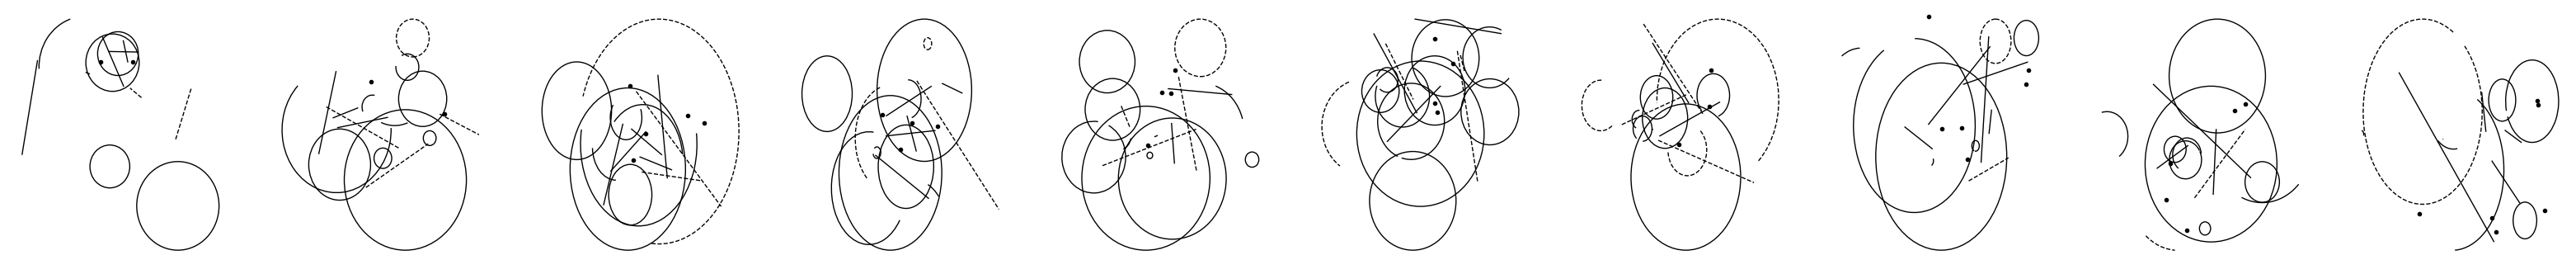

Iter Loss: 0.24749794602394104:  40%|███▉      | 19999/50000 [1:06:33<1:33:15,  5.36it/s] 

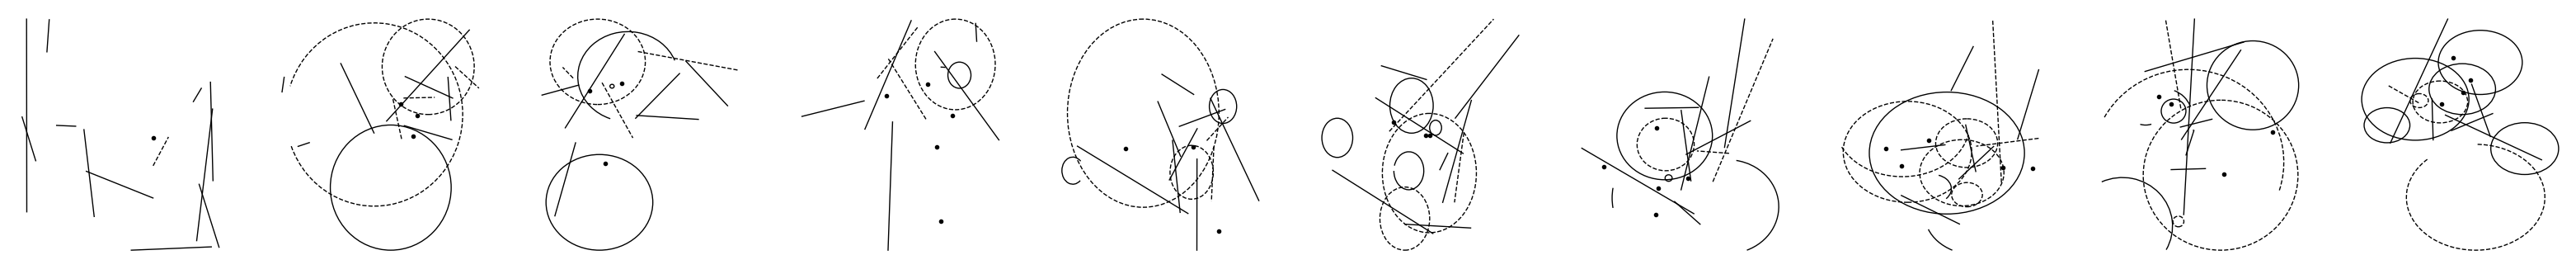

Iter Loss: 0.4520779550075531:  56%|█████▌    | 27869/50000 [1:31:39<1:12:47,  5.07it/s]  


KeyboardInterrupt: 

: 

In [23]:
model.train()
pbar = tqdm(range(num_train_iters))
for step in pbar:
    optimizer.zero_grad()

    # t = torch.rand(size = (16,), device = gpu_id)
    # alpha = 0.5
    # beta = 0.25
    # # Smaller beta% of timesteps should have alpha% chance of occuring 
    # t = (torch.where(t < alpha, t * beta/alpha, (t - alpha) * (1 - beta)/(1 - alpha) + beta) * model.max_timestep).int()
    
    # sdev = model.noise_scheduler.sqrt_cumulative_variances[t].to(gpu_id)
    scales = torch.ones(size = (16,)).to(gpu_id) # model.noise_scheduler.sqrt_cumulative_precisions[t].to(gpu_id).clamp(0.5)
    t = torch.randint(low = 1, high = model.max_timestep, size = (16,)).to(gpu_id)
    # t = (timestep_distribution.sample([16,]).squeeze(-1) * model.max_timestep).int().to(gpu_id)
        
    noised_nodes, noised_edges, true_noise = model.noise_scheduler(nodes, edges, t)

    pred_nodes, pred_edges = model(noised_nodes, noised_edges, t)

    loss_dict = {}

    loss = diffusion_loss(pred_nodes, pred_edges, nodes, edges, params_mask, true_noise, scales, loss_dict)

    plot_loss(writer, loss_dict, step)
    pbar.set_description(f"Iter Loss: {loss.item()}")

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    # monitor.update()
    optimizer.step()
    model.update_ema()
    # scheduler.step()
    # writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0], step)

    if step % 10_000 == 9_999:
        model.eval()
        model.sample(1)
        model.train()

In [ ]:
# model.train()
# pbar = tqdm(range(num_train_iters))
# for step in pbar:
#     optimizer.zero_grad()

#     t = torch.randint(low = 1, high = model.max_timestep, size = (16,)).to(gpu_id)
#     # t = (timestep_distribution.sample((16,)) * (t_max + 1)).squeeze().int()
        
#     noised_nodes, noised_edges, true_noise = model.noise_scheduler(nodes, edges, t)
#     # scale = model.noise_scheduler.cumulative_precisions[t] # Proportion of original graph in noisy version

#     pred_nodes, pred_edges = model(noised_nodes, noised_edges, t)

#     loss_dict = {}

#     # noised_params = noised_nodes[...,6:]
#     # pred_params = pred_nodes[...,6:]
#     # sqrt_cumul_prec = model.noise_scheduler.sqrt_cumulative_precisions[t,None,None]
#     # sqrt_cumul_var = model.noise_scheduler.sqrt_cumulative_variances[t,None,None]
#     # pred_noise = (noised_params - sqrt_cumul_prec * pred_params) / sqrt_cumul_var

#     # if torch.isnan(pred_noise).any():
#     #     x = 5

#     loss = diffusion_loss(pred_nodes, pred_edges, nodes, edges, params_mask, true_noise, loss_dict)

#     plot_loss(writer, loss_dict, step)
#     pbar.set_description(f"Iter Loss: {loss.item()}")

#     loss.backward()
#     # torch.nn.utils.clip_grad_norm_(model.parameters(), 5e-1)
#     optimizer.step()

#     if step % 1000 == 999:
#         model.sample(1)

### Validate Loop

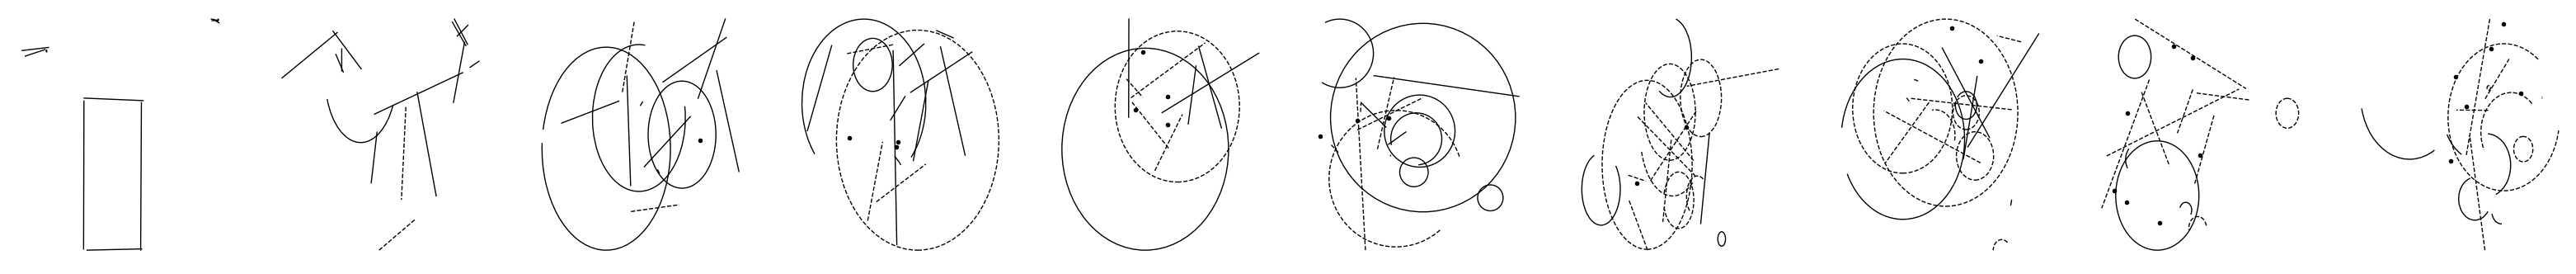

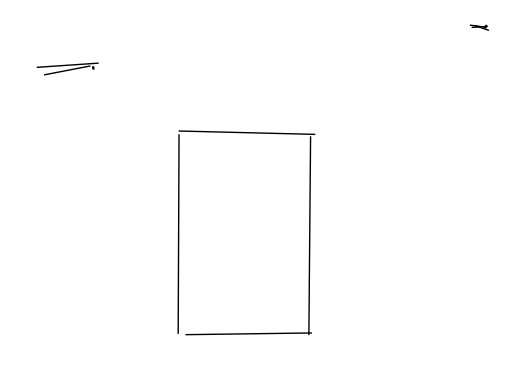

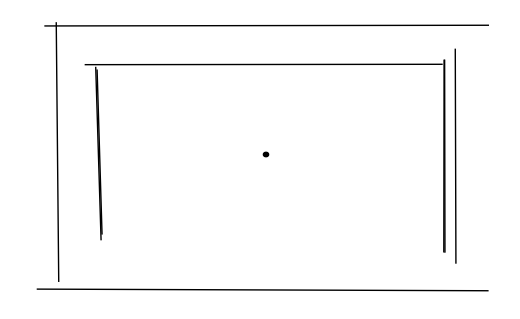

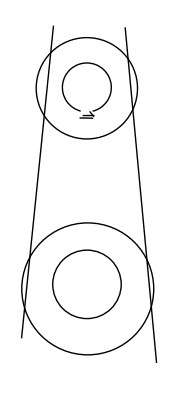

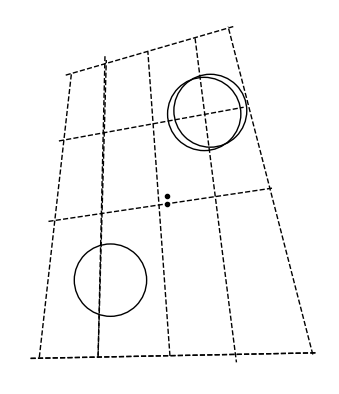

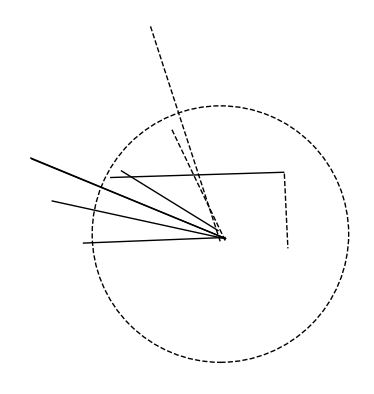

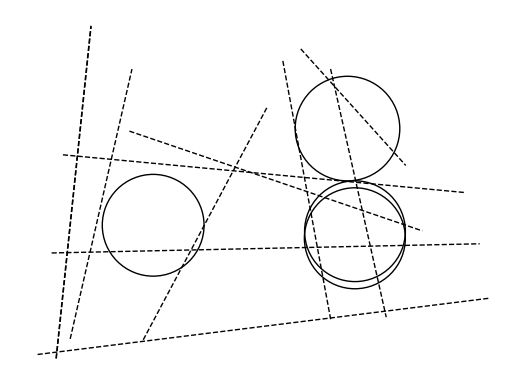

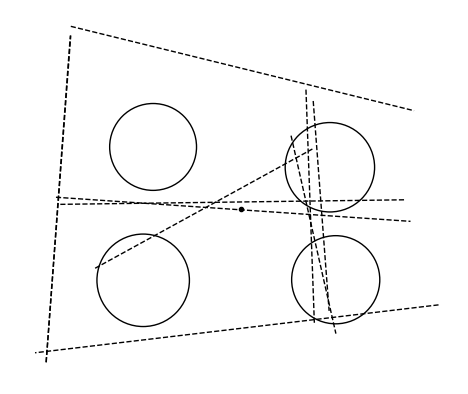

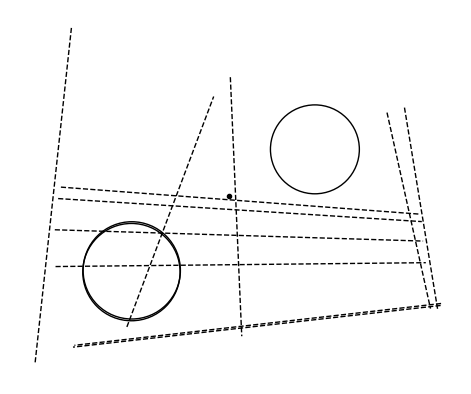

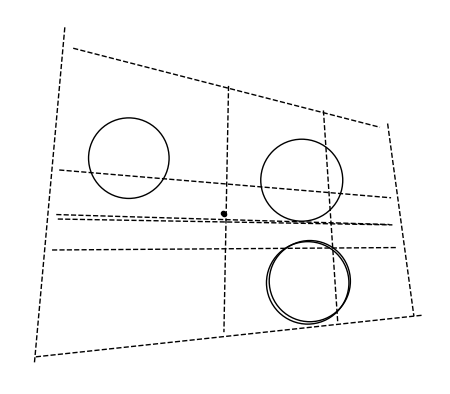

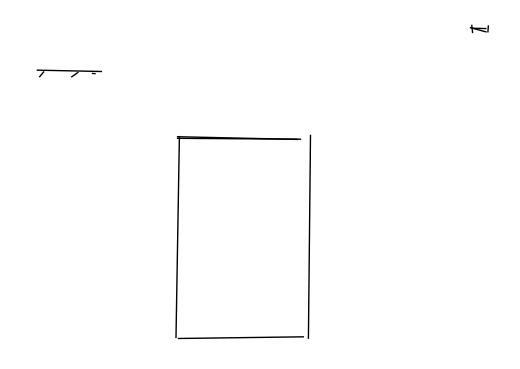

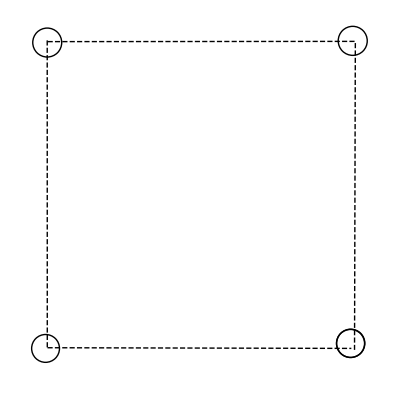

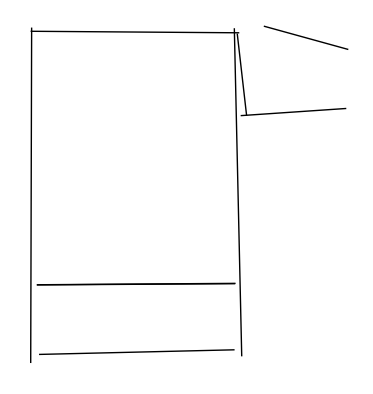

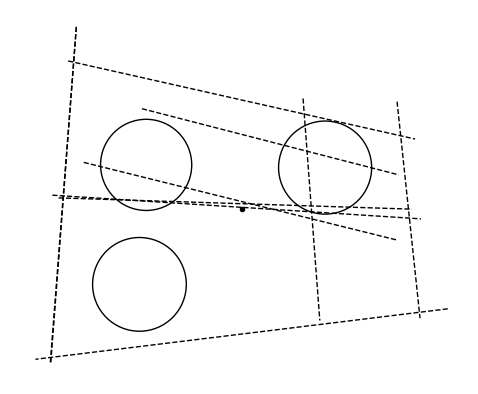

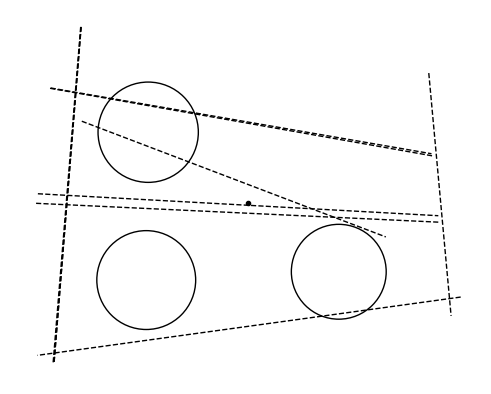

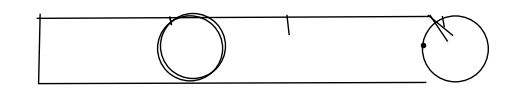

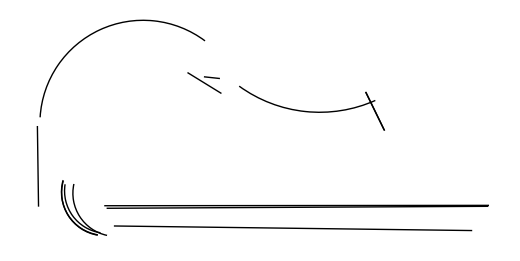

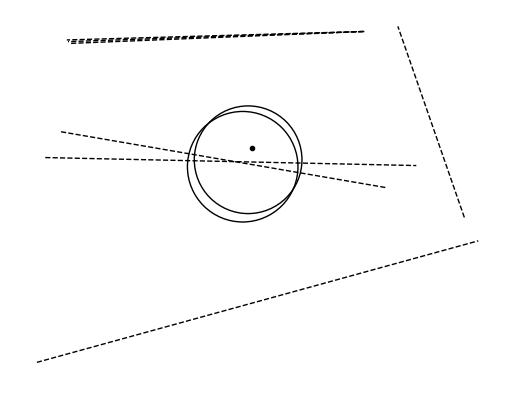

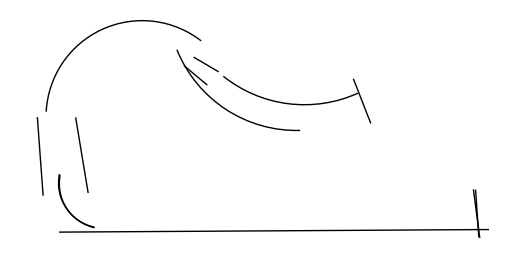

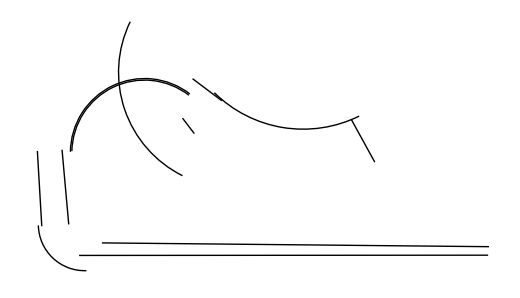

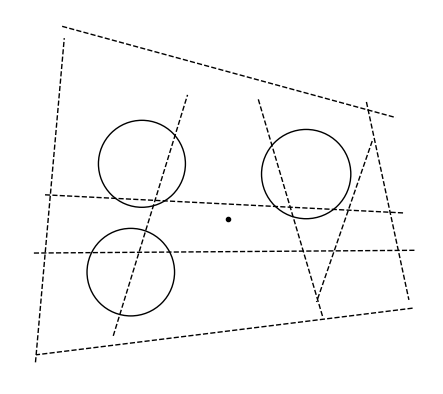

In [ ]:
model.eval()
with torch.no_grad():
    temp_nodes, temp_edges = model.sample(20)

    for i in range(temp_nodes.size(0)):
        SketchDataset.render_graph(temp_nodes[i].cpu(), temp_edges[i].cpu())

In [ ]:
# model.eval()
# graph_idx = 2
# frames = 20
# fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16, 4))
# fig.suptitle("True - Noised - Pred - Next")

# def animation_fun(frame : int, curr_nodes : Tensor, curr_edges : Tensor, axes):
#     timestep = t_max - frame

#     pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([timestep]).int())
#     # Normalize output into probabilities
#     pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
#     pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
#     pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
#     pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
#     pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
#     # Reverse Step
#     new_nodes, new_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, timestep)
#     # curr_nodes, curr_edges = model.reverse_step(curr_nodes, curr_edges, nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), timestep)
    
#     for ax in axes:
#         ax.cla()
    
#     SketchDataset.render_graph(nodes[graph_idx].cpu().squeeze(0), edges[graph_idx].cpu().squeeze(0), axes[0])
#     SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[1])
#     SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[2])
#     SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[3])

#     curr_nodes[...] = new_nodes
#     curr_edges[...] = new_edges

# curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), t_max)
# animation = FuncAnimation(fig = fig, func = partial(animation_fun, curr_nodes = curr_nodes, curr_edges = curr_edges, axes = axes), frames = frames, interval = 200, repeat_delay = 1000)

# video = animation.to_html5_video()
# display.display(display.HTML(video))
# plt.close()


In [ ]:
# model.eval()
# graph_idx = 0
# timestep = 40
# fig, axes = plt.subplots(nrows = timestep, ncols = 4, figsize=(16, 1 * timestep))
# plt.margins(y=0)
# fig.suptitle("True - Noised - Pred - Next")

# # Noise graph
# curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), timestep)

# for t in reversed(range(1, timestep + 1)):
#     # Predict true graph
#     pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([t]).int())
#     # Normalize output into probabilities
#     pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
#     pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
#     pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
#     pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
#     pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
#     # Run one denoising step
#     new_nodes, new_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, t)

#     fig_idx = timestep - t
#     SketchDataset.render_graph(nodes[graph_idx].cpu(), edges[graph_idx].cpu(), axes[fig_idx, 0])
#     SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[fig_idx, 1])
#     SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[fig_idx, 2])
#     SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[fig_idx, 3])

#     curr_nodes = new_nodes
#     curr_edges = new_edges

In [ ]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# # model.eval()
# graph_idx = 2
# t = 2

# # Noise graph
# curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].to(6).unsqueeze(0), edges[graph_idx].to(6).unsqueeze(0), t)
# # Predict true graph
# pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([t]).int())
# # Normalize output into probabilities
# pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
# pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
# pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
# pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
# pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
# # Run one denoising step
# curr_nodes, curr_edges = model.reverse_step(curr_nodes, curr_edges, nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), t)
# cur1_nodes, cur1_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, t)

# fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
# SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[0])
# SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[1])

In [ ]:
# x = torch.randint(low = 0, high = 10, size = (2, 3, 4)).float()
# print(x)

# dims = list(range(x.dim()))[1:-1]
# print(dims)

# mean = x.mean(dim = dims, keepdim = True)
# print(mean)

# sdev = ((x - mean) ** 2).mean(dim = dims, keepdim = True).sqrt()

# print(sdev)

In [ ]:
# gpu_id = 0
# D = 5
# x0 = torch.eye(n = 1, m = D, device = gpu_id)
# ln_s = -10
# t = torch.arange(0, 1, 1 / (1000 + 1), device = gpu_id)
# sqrt_cumulative_precisions = CosineNoiseScheduler(1000, device = gpu_id).sqrt_cumulative_precisions
# a_bar = sqrt_cumulative_precisions.unsqueeze(1)
# temp = x0.log().clamp(ln_s)
# a_bar = torch.sum(torch.log(D * a_bar * x0 + (1 - a_bar)) * temp, dim = -1) / (temp * temp).sum(dim = -1)
# a_bar = (1 + a_bar ** -2) ** -1

# plt.plot(t.cpu(), a_bar.cpu())

# alpha = torch.zeros(1, device = gpu_id)
# # norm = torch.zeros(1, device = gpu_id)
# for i in range(1000):
#     x = x0.expand(100000, -1)
#     noise = torch.randn_like(x)
#     # noise = -torch.log(-torch.log(torch.rand_like(x)))

#     latent = torch.sqrt(a_bar[i]) * x.log().clamp(-10) + torch.sqrt(1 - a_bar[i]) * noise

#     y = F.one_hot(torch.argmax(latent, dim = -1), D).float().mean(0)

#     temp_alpha = y[0] # ((y - 1/D) * (x0 - 1/D)).sum() / (1 - 1/D)

#     alpha = torch.cat([alpha, temp_alpha.unsqueeze(0)], dim = -1)

#     # print(y)

#     # temp_norm = (latent * latent).sum(-1).sqrt().mean()

#     # norm = torch.cat([norm, temp_norm.unsqueeze(0)], dim = -1)

#     # print(latent[0])


# alpha = alpha.squeeze(0)[1:]
# # norm = norm.squeeze(0)[1:]

# plt.plot(t[1:].cpu(), alpha.cpu())
# plt.axhline(y=1/D, color='g', linestyle=':', label='1/D')
# plt.axhline(y=0, color='r', linestyle=':', label='0')
# plt.legend()
# # print(alpha)
# # plt.plot(t[1:].cpu(), norm.cpu())

In [ ]:
# mean = torch.full((1,), 0).to(gpu_id) # * a_bar.sqrt()[1:]
# std = 1 # torch.sqrt(1 - a_bar)[1:]
# normalized = (0 - mean) / ((2 ** 0.5) * std)
# cdf = 0.5 * (1 + torch.erf(normalized))
# cdf = cdf ** 3 # ** (D)

# print(cdf)
# # plt.plot(t[1:].cpu(), cdf.cpu())

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import integrate
# from scipy.stats import norm

# def prob_argmax_first_diff_mean(n, mu0, mu, sigma, num_samples=100000):
#     # Numerical integration using NumPy/SciPy
#     def integrand(x):
#         return (norm.cdf((x - mu) / sigma) ** (n-1)) * \
#                norm.pdf((x - mu0) / sigma) / sigma
    
#     result, _ = integrate.quad(integrand, -np.inf, np.inf)
#     return result

# # Monte Carlo simulation for verification
# def monte_carlo_prob(n, mu0, mu, sigma, num_samples=100000):
#     x0 = torch.normal(mu0, sigma, (num_samples, 1))
#     others = torch.normal(mu, sigma, (num_samples, n-1))
#     return (x0 > others.max(dim=1, keepdim=True)[0]).float().mean().item()

# # Parameters
# n = 5  # number of elements
# sigma = 1.0  # standard deviation
# mu = 0.0  # mean of other elements

# # Compute probabilities for different mu0
# mu0_range = np.linspace(-2, 2, 100)
# probs_numerical = [prob_argmax_first_diff_mean(n, mu0, mu, sigma) for mu0 in mu0_range]
# probs_monte_carlo = [monte_carlo_prob(n, mu0, mu, sigma) for mu0 in mu0_range]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(mu0_range, probs_numerical, 'b-', label='Numerical Integration')
# plt.plot(mu0_range, probs_monte_carlo, 'r--', label='Monte Carlo')
# plt.axhline(y=1/n, color='g', linestyle=':', label='1/n')
# plt.xlabel('μ₀ (mean of first element)')
# plt.ylabel('Probability')
# plt.title(f'Probability of argmax being the first element (n={n}, μ={mu}, σ={sigma})')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print some specific values
# print(f"For μ₀ = -1: {prob_argmax_first_diff_mean(n, -1, mu, sigma):.4f}")
# print(f"For μ₀ = 0: {prob_argmax_first_diff_mean(n, 0, mu, sigma):.4f}")
# print(f"For μ₀ = 1: {prob_argmax_first_diff_mean(n, 1, mu, sigma):.4f}")

In [ ]:
# x = torch.arange(5).unsqueeze(1).expand(5, 8)

# x.reshape(5, 4, 2).permute(1, 0, 2)

In [ ]:
# def batched_dot(a : Tensor, b : Tensor):
#     return (a * b).sum(dim = -1, keepdim = True)

# m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = gpu_id).to(torch.double)

# # To Iscosceles representation
# x = nodes.clone().to(torch.double)
# c = x[...,13:15] # torch.tensor([1.76, 2.21])
# r = x[...,15,None] # torch.tensor([1.0])
# alpha = x[...,16,None] * 2 * math.pi # torch.tensor([0.211])
# beta = x[...,17,None] * 2 * math.pi # torch.tensor([0.987])

# a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
# b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)
# r_s = torch.where(batched_dot((a - b) @ m, a - c) > 0, -r, r)

# # To Naive representation
# d = a - b

# w = batched_dot(d, d).sqrt()
# h = torch.sqrt(r ** 2 - w ** 2 / 4)

# center = b + d / 2 + h / w * d @ m * r_s.sign()

# al = (a - c) / r_s.abs()
# al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
# be = (b - c) / r_s.abs()
# be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

# new_x = x.clone().to(torch.double)
# new_x[...,13:18] = torch.cat([center, torch.abs(r_s), al, be], dim = -1)
# new_x[new_x.isnan()] = 0
# new_x = new_x.to(torch.float)

# i = 6
# SketchDataset.render_graph(nodes[i].cpu(), edges[i].cpu())
# SketchDataset.render_graph(ToNaive(ToIscosceles(nodes[i])).cpu(), edges[i].cpu())
# print("")

# x = nodes.clone()

# center = x[...,13:15]
# radius = x[...,15,None]
# alpha = x[...,16,None] * 2 * math.pi
# beta = x[...,17,None] * 2 * math.pi
# a = center + radius * torch.cat([torch.cos(alpha), torch.sin(alpha)], dim = -1)
# b = center + radius * torch.cat([torch.cos(beta), torch.sin(beta)], dim = -1)

# orthogonal = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = gpu_id)

# sign = batched_dot((a - b) @ orthogonal, a - center)
# r = torch.where(sign > 0, -radius, radius)
# y = torch.cat([a, r, b], dim = -1)

# w = batched_dot(a - b, a - b).sqrt()

# h = torch.sqrt(r ** 2 - w ** 2 / 4)
# c = b + (a - b) / 2 + h / w * (a - b) @ orthogonal * torch.sign(r)
# al = (torch.atan2((a - c)[...,1,None] / r.abs(), (a - c)[...,0,None] / r.abs()) % (2*math.pi)) / (2 * math.pi)
# be = (torch.atan2((b - c)[...,1,None] / r.abs(), (b - c)[...,0,None] / r.abs()) % (2*math.pi)) / (2 * math.pi)

# new_x = x.clone()
# new_x[...,13:18] = torch.cat([c, torch.abs(r), al, be], dim = -1)

In [ ]:
# t = torch.tensor([0, 1, 0, 0, 0, 0, 0])
# x = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
# x[torch.nonzero(t).squeeze(-1)].shape

torch.Size([1, 2])